In [226]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfTransformer

In [227]:
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Microsoft YaHei', 'Heiti TC', 'STHeiti']
plt.rcParams['axes.unicode_minus'] = False 

# 全局样式
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'  # 白色背景
plt.rcParams['axes.facecolor'] = 'white'

In [228]:

from matplotlib import font_manager

# 2. 全局字体配置（解决中文显示乱码问题，适配Windows/Mac/Linux）
def set_global_font():
    # 优先使用系统已有的中文字体（避免手动下载字体）
    try:
        # Windows系统常用中文字体
        font_manager.fontManager.addfont("C:/Windows/Fonts/msyh.ttc")  # 微软雅黑
        plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'Arial Unicode MS']
    except:
        try:
            # Mac系统常用中文字体
            font_manager.fontManager.addfont("/Library/Fonts/Songti.ttc")  # 宋体
            plt.rcParams['font.sans-serif'] = ['Songti SC', 'Arial Unicode MS']
        except:
            #  Linux或无中文字体时，用默认英文+兼容字体
            plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'DejaVu Sans']
    # 解决负号显示异常问题
    plt.rcParams['axes.unicode_minus'] = False

# 3. 全局绘图风格配置（统一颜色、线条、图例等样式）
def set_global_plot_style():
    # 方案1：使用seaborn预设风格（简洁美观，推荐）
    sns.set_style("whitegrid")  # 白色网格背景，突出数据；可选"darkgrid"（深色网格）
    sns.set_palette("viridis")  # 全局配色方案（viridis友好且专业，可选"coolwarm"/"Blues"）
    
    # 方案2：自定义matplotlib全局参数（如需更精细控制，可替换方案1）
    # plt.rcParams['figure.figsize'] = (10, 6)  # 图表默认尺寸（宽, 高）
    # plt.rcParams['axes.labelpad'] = 10  # 坐标轴标签与轴的间距
    # plt.rcParams['legend.fontsize'] = 10  # 图例字体大小
    # plt.rcParams['axes.titlesize'] = 14  # 图表标题字体大小
    # plt.rcParams['axes.labelsize'] = 12  # 坐标轴标签字体大小
    # plt.rcParams['xtick.labelsize'] = 10  # x轴刻度字体大小
    # plt.rcParams['ytick.labelsize'] = 10  # y轴刻度字体大小
    # plt.rcParams['lines.linewidth'] = 2  # 线条宽度
    # plt.rcParams['scatter.edgecolors'] = 'white'  # 散点图边缘色（突出散点）

# 4. 执行全局配置（只需运行一次，全脚本生效）
set_global_font()
set_global_plot_style()

# ---------------------- 以下是你的原有代码 ----------------------
# 例如：数据读取、清洗、分析等
# steam = pd.read_csv(r'steam.csv')
# ...

# 探索性数据分析(EDA)—业务现状诊断
## 提出三个分析目标
1.	游戏发行生态诊断：分析 Steam 平台游戏发行年份分布、TOP30 开发商 / 发行商的作品产出节奏与类型偏好，定位 “发行高峰期特征” 与 “高产主体的核心竞争力”，为中小开发者选择合作发行商、规划发行时机提供参考。
2.	玩家拥有量分层洞察：基于玩家拥有量（owners_est）的分箱结果，识别 “小众游戏（<5 万拥有量）、腰部游戏（5-100 万拥有量）、头部游戏（>100 万拥有量）” 的数量占比与标签共性，明确不同量级游戏的市场格局，为开发者判断目标用户规模、制定市场定位策略提供依据。
3.	平台市场价值评估：统计 Windows/macOS/Linux 三大平台的游戏覆盖量、价格区间分布及 “支持多平台游戏” 的占比，量化不同平台的 “用户渗透价值” 与 “商业化潜力”，为开发者决定平台适配优先级提供数据支撑。



## 1 游戏发行生态诊断

### 1.1 steam平台游戏发行量时间序列分析
- 识别游戏发行爆发节点
- 监测周期规律和整体趋势

In [229]:
#读入原始数据
steam=pd.read_csv(r'steam.csv')
print(steam.isnull().sum())
steam.head(20)

appid               0
name                0
release_date        0
english             0
developer           0
publisher           0
platforms           0
required_age        0
categories          0
genres              0
steamspy_tags       0
achievements        0
positive_ratings    0
negative_ratings    0
average_playtime    0
median_playtime     0
owners              0
price               0
dtype: int64


,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99
5,60,Ricochet,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Valve Anti-Ch...,Action,Action;FPS;Multiplayer,0,2758,684,175,10,5000000-10000000,3.99
6,70,Half-Life,1998-11-08,1,Valve,Valve,windows;mac;linux,0,Single-player;Multi-player;Online Multi-Player...,Action,FPS;Classic;Action,0,27755,1100,1300,83,5000000-10000000,7.19
7,80,Counter-Strike: Condition Zero,2004-03-01,1,Valve,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,Action;FPS;Multiplayer,0,12120,1439,427,43,10000000-20000000,7.19
8,130,Half-Life: Blue Shift,2001-06-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player,Action,FPS;Action;Sci-fi,0,3822,420,361,205,5000000-10000000,3.99
9,220,Half-Life 2,2004-11-16,1,Valve,Valve,windows;mac;linux,0,Single-player;Steam Achievements;Steam Trading...,Action,FPS;Action;Sci-fi,33,67902,2419,691,402,10000000-20000000,7.19


In [230]:
#缺失值较少，直接删去缺失值所在行
steam.dropna(inplace=True)
#去重
steam.drop_duplicates(inplace=True)
steam.reset_index(drop=True,inplace=True)
#查看数据基本信息
steam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27075 entries, 0 to 27074
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   appid             27075 non-null  int64  
 1   name              27075 non-null  object 
 2   release_date      27075 non-null  object 
 3   english           27075 non-null  int64  
 4   developer         27075 non-null  object 
 5   publisher         27075 non-null  object 
 6   platforms         27075 non-null  object 
 7   required_age      27075 non-null  int64  
 8   categories        27075 non-null  object 
 9   genres            27075 non-null  object 
 10  steamspy_tags     27075 non-null  object 
 11  achievements      27075 non-null  int64  
 12  positive_ratings  27075 non-null  int64  
 13  negative_ratings  27075 non-null  int64  
 14  average_playtime  27075 non-null  int64  
 15  median_playtime   27075 non-null  int64  
 16  owners            27075 non-null  object

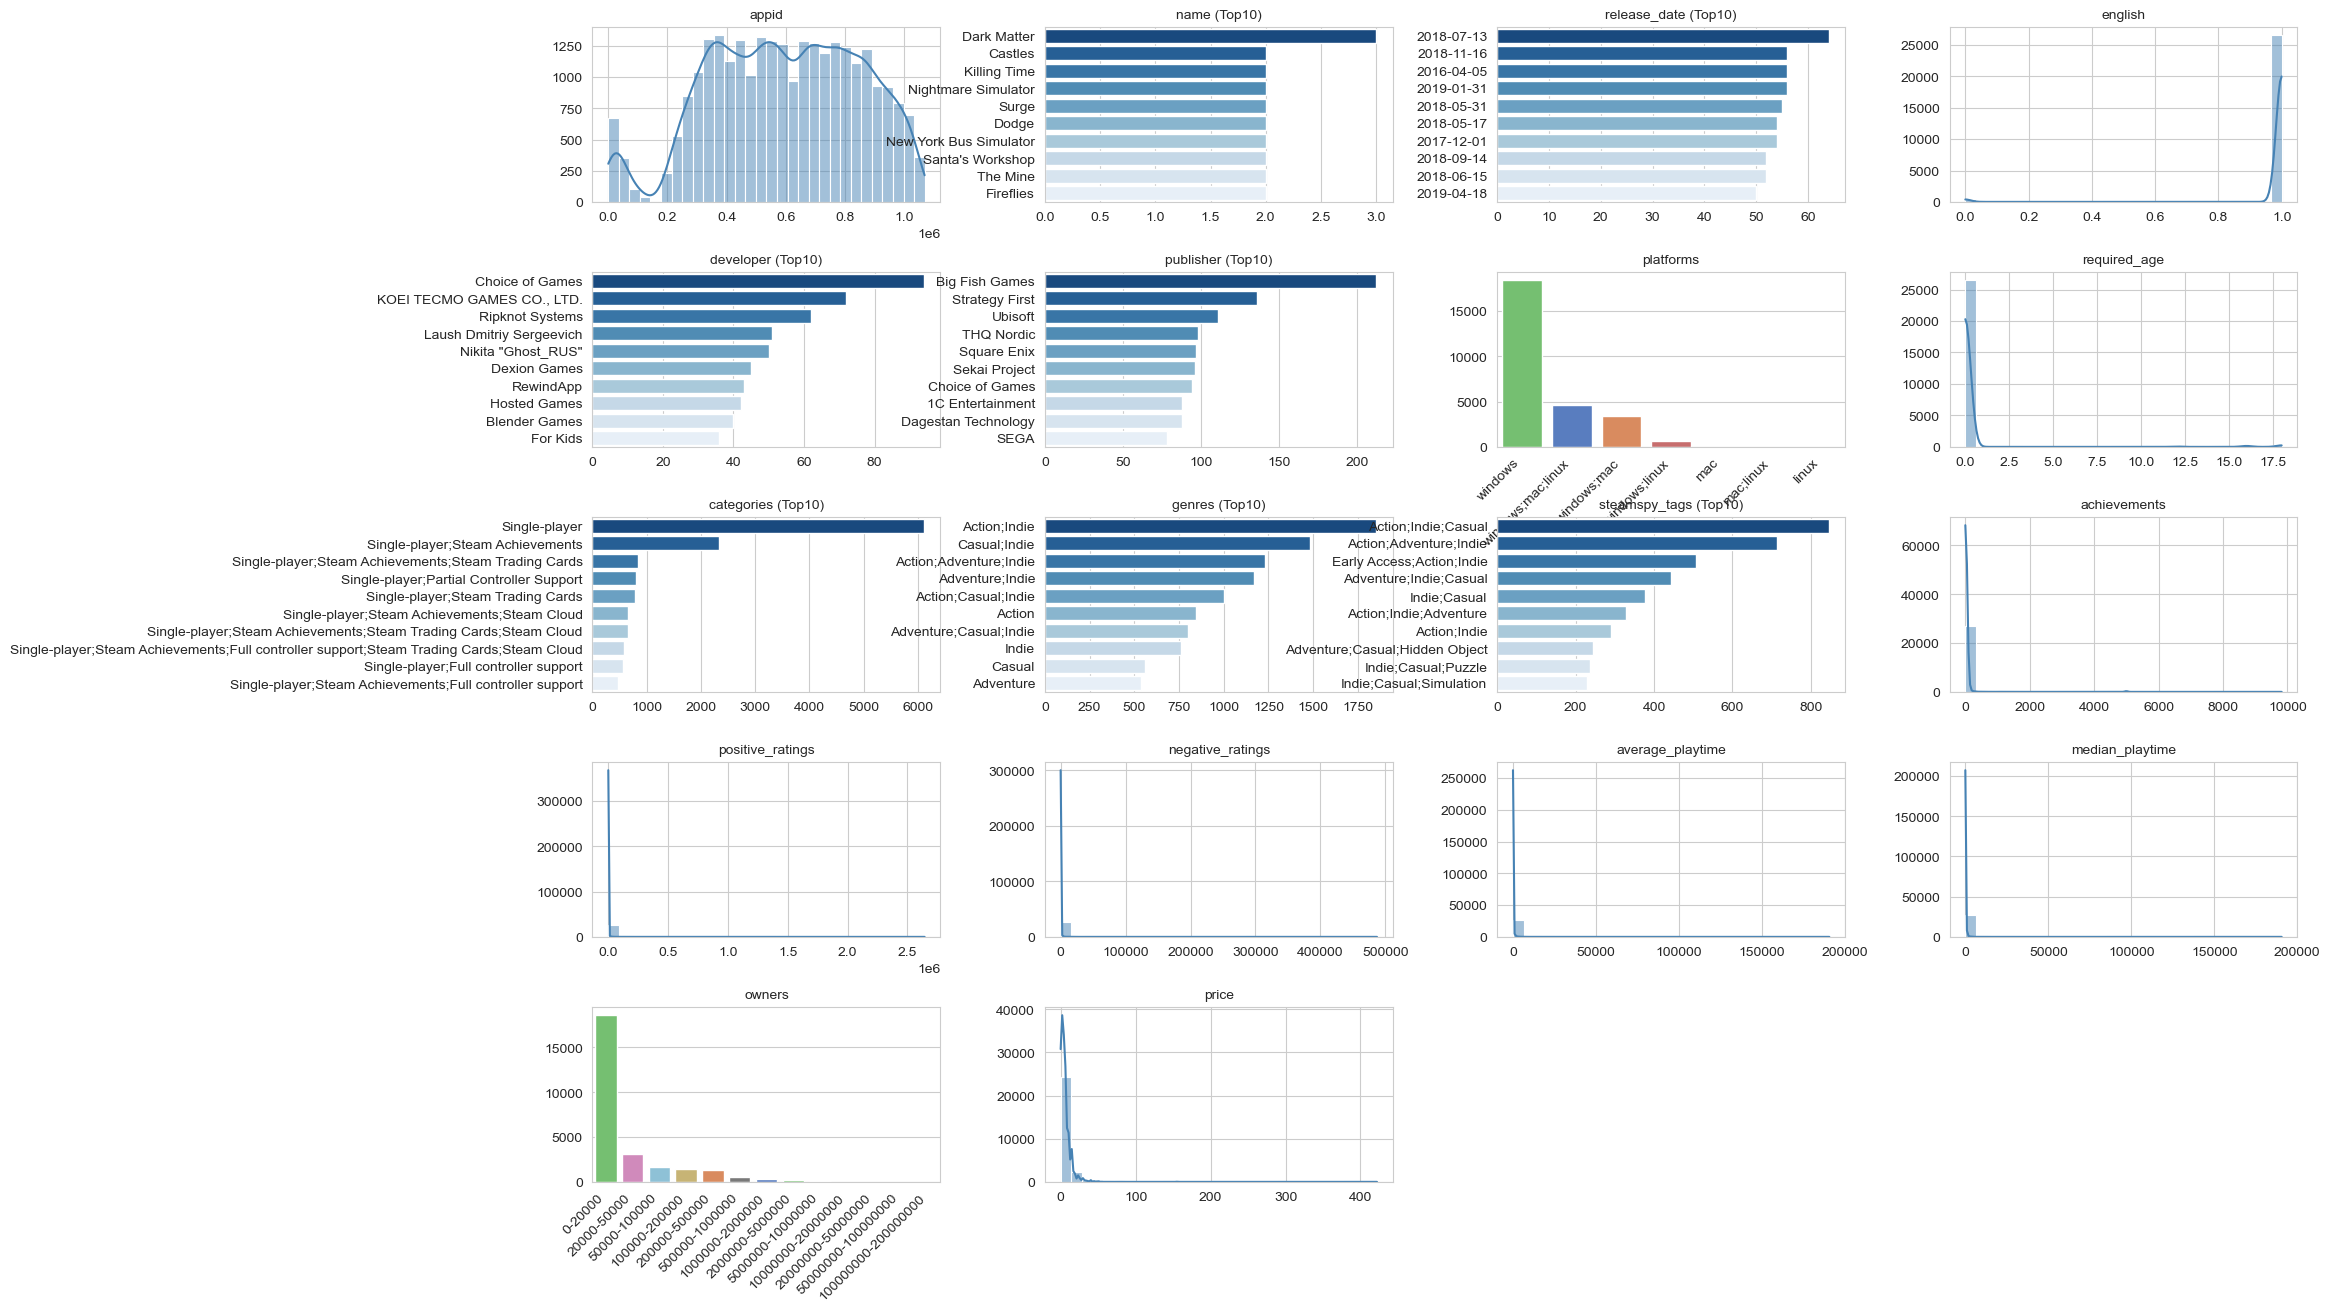

In [231]:
cols = steam.columns
n_cols = len(cols)
n_rows = int(np.ceil(n_cols / 4))
fig, axes = plt.subplots(n_rows, 4, figsize=(22, n_rows * 3))
axes = axes.flatten()

for i, col in enumerate(cols):
    ax = axes[i]
    try:
        if pd.api.types.is_numeric_dtype(steam[col]):
            sns.histplot(steam[col], kde=True, bins=30, color='steelblue', ax=ax)
            ax.set_title(col, fontsize=10)
        elif steam[col].nunique() < 15:
           
            sns.countplot(
                data=steam,
                x=col,
                hue=col,
                order=steam[col].value_counts().index,
                palette='muted',
                legend=False,
                ax=ax
            )
            ax.set_title(col, fontsize=10)
            for label in ax.get_xticklabels():
                label.set_rotation(45)
                label.set_ha('right')
        else:
            # 高基数列取 Top10
            top_vals = steam[col].value_counts().head(10).reset_index()
            top_vals.columns = ['value', 'count']
            sns.barplot(
                data=top_vals,
                x='count',
                y='value',
                hue='value',
                palette='Blues_r',
                legend=False,
                ax=ax
            )
            ax.set_title(f"{col} (Top10)", fontsize=10)
        ax.set_xlabel('')
        ax.set_ylabel('')
    except Exception as e:
        ax.text(0.5, 0.5, f"Error: {e}", ha='center', va='center', fontsize=8)
        ax.set_title(f"{col}", fontsize=10)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

In [232]:
#查看时间区间
steam['release_date']=pd.to_datetime(steam['release_date'],errors='coerce')
start = steam['release_date'].min()
end = steam['release_date'].max()
print(f"数据时间范围从 {start} 到 {end}")

数据时间范围从 1997-06-30 00:00:00 到 2019-05-01 00:00:00


可是2003年之前steam平台并未上线，查看异常纪录

In [233]:
pre_2003 = steam[steam['release_date'].dt.year < 2003]
print(pre_2003[['name', 'release_date', 'developer', 'publisher']])

                           name release_date            developer  \
0                Counter-Strike   2000-11-01                Valve   
1         Team Fortress Classic   1999-04-01                Valve   
3            Deathmatch Classic   2001-06-01                Valve   
4     Half-Life: Opposing Force   1999-11-01     Gearbox Software   
5                      Ricochet   2000-11-01                Valve   
6                     Half-Life   1998-11-08                Valve   
8         Half-Life: Blue Shift   2001-06-01     Gearbox Software   
778                       Mafia   2002-08-28   Illusion Softworks   
988                    Gothic 1   2001-03-15        Piranha Bytes   
1185                Geneforge 1   2001-12-01   Spiderweb Software   
2685       Carmageddon Max Pack   1997-06-30  Stainless Games Ltd   

               publisher  
0                  Valve  
1                  Valve  
3                  Valve  
4                  Valve  
5                  Valve  
6        

经过调研，这些游戏是在2003年之前以其他手段发行，后兼容于steam平台

In [234]:
#删除2003年之前的数据
steam = steam[steam['release_date'].dt.year >= 2003].copy()
steam.reset_index(drop=True, inplace=True)

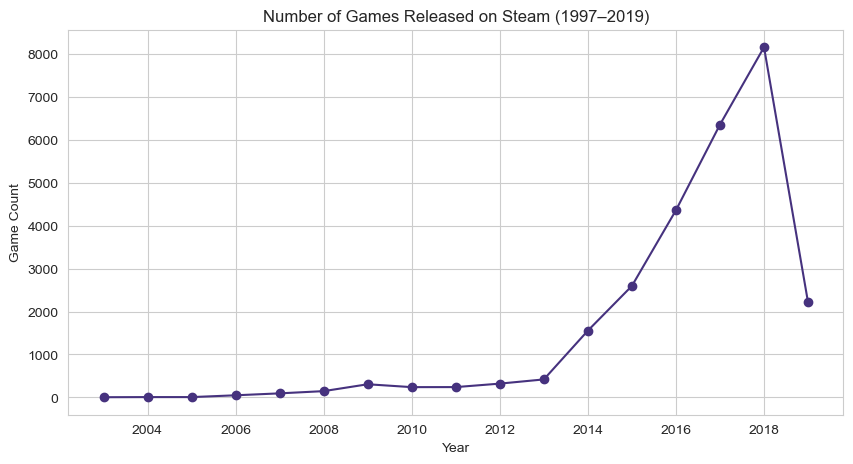

In [235]:
# 提取年份
steam['year'] = steam['release_date'].dt.year

# 按年统计游戏数量
yearly_counts = steam.groupby('year').size().reset_index(name='game_count')

# 去掉异常年份（比如 0 或未来年份）
yearly_counts = yearly_counts[(yearly_counts['year'] >= 1997) & (yearly_counts['year'] <= 2019)]

# 绘制时间序列图
plt.figure(figsize=(10, 5))
plt.plot(yearly_counts['year'], yearly_counts['game_count'], marker='o')
plt.title('Number of Games Released on Steam (1997–2019)')
plt.xlabel('Year')
plt.ylabel('Game Count')
plt.grid(True)
plt.show()

该序列早期阶段表现出近乎零的发布频率，暗示在市场扩张前存在一段长时间的休眠期。

**定义当年发行数达到峰值的10%时，视为市场开始“显著活跃”的年份**
- 优点：直观、鲁棒，适合像 Steam 这样前期数据极少、后期爆发的分布。

In [236]:
threshold = 0.1 * yearly_counts['game_count'].max()
transition_year = yearly_counts.loc[yearly_counts['game_count'] > threshold, 'year'].min()
print("市场开始活跃的年份大约是：", transition_year)

市场开始活跃的年份大约是： 2014


为更细致地刻画 2014 年后市场的动态变化，将时间粒度细化至月份。月份序列表现出阶段性波动与周期性高峰，反映出平台在不同季节的发行节奏与市场活跃度。

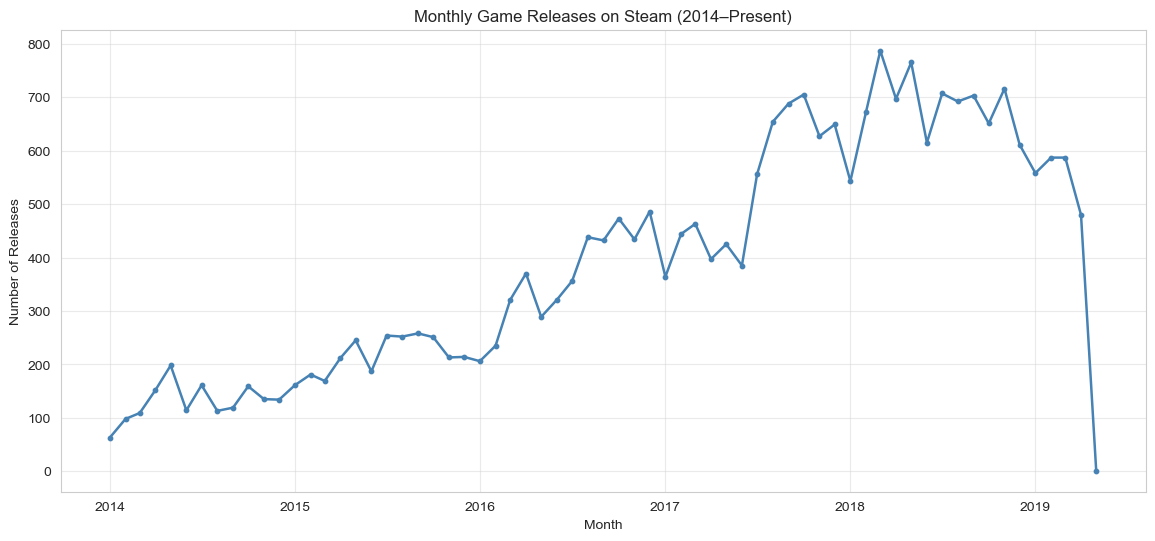

In [237]:
# 1. 筛选 2014 年及以后的数据
steam_after_2014 = steam[steam['release_date'].dt.year >= 2014].copy()

# 2. 提取“年月”特征
steam_after_2014['month'] = steam_after_2014['release_date'].dt.to_period('M')

# 3. 按月统计发行数
monthly_counts = (
    steam_after_2014
    .groupby('month')
    .size()
    .reset_index(name='game_count')
)

# 4. 转换为时间戳，便于绘图
monthly_counts['month'] = monthly_counts['month'].dt.to_timestamp()

# 5. 绘制时间序列图
plt.figure(figsize=(14, 6))
plt.plot(monthly_counts['month'], monthly_counts['game_count'], color='steelblue', linewidth=1.8)
plt.scatter(monthly_counts['month'], monthly_counts['game_count'], color='steelblue', s=10)
plt.title('Monthly Game Releases on Steam (2014–Present)')
plt.xlabel('Month')
plt.ylabel('Number of Releases')
plt.grid(alpha=0.4)
plt.show()

**注意**： 最后一个月份数据较少，数值接近零，参考意义有限。

按月份统计平均发行量：缺点在于可能会被个别年份同月极端值拉偏

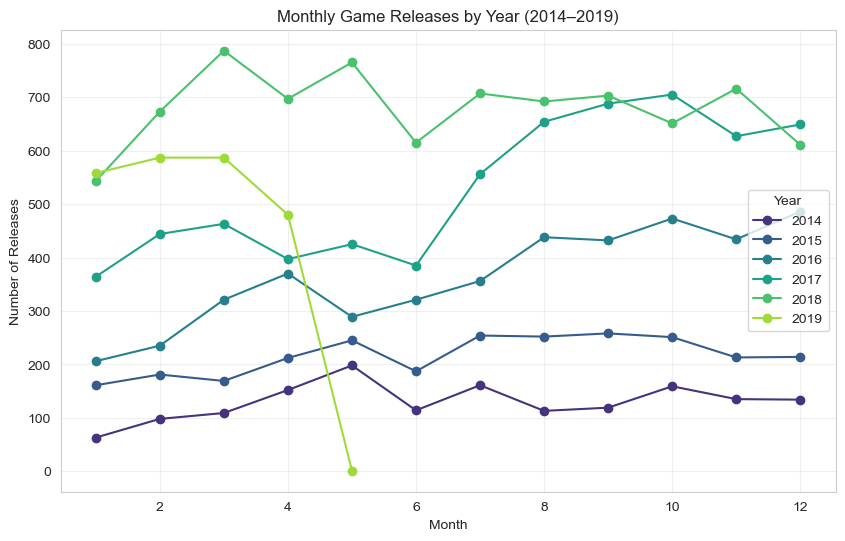

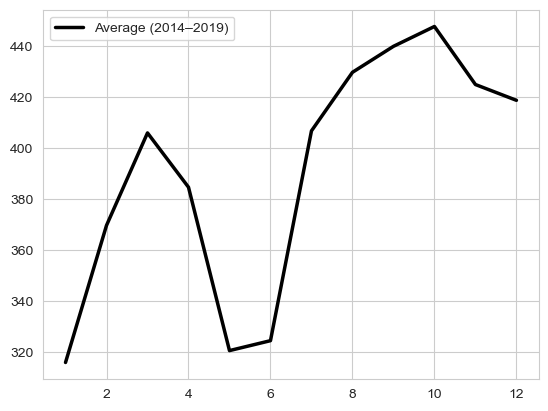

In [238]:
import matplotlib.pyplot as plt
import pandas as pd

# 假设 monthly_counts 已经包含两列：'month'（Timestamp类型） 和 'game_count'
monthly_counts['year'] = monthly_counts['month'].dt.year
monthly_counts['month_num'] = monthly_counts['month'].dt.month

# 按年份绘制每年的月度发行趋势线
plt.figure(figsize=(10,6))
for year, group in monthly_counts.groupby('year'):
    plt.plot(group['month_num'], group['game_count'], marker='o', label=str(year))

plt.title('Monthly Game Releases by Year (2014–2019)')
plt.xlabel('Month')
plt.ylabel('Number of Releases')
plt.legend(title='Year')
plt.grid(alpha=0.3)
plt.show()

#平均线
avg_pattern = monthly_counts.groupby('month_num')['game_count'].mean()
plt.plot(avg_pattern.index, avg_pattern.values, color='black', linewidth=2.5, label='Average (2014–2019)')
plt.legend()

发行高峰出现在3-4月，后半年整体发行量都较高。

原假设 $H_0$：各月游戏发行数量的均值无显著差异（即不存在季节性）；

In [239]:
import pandas as pd
from scipy.stats import kruskal

# 假设 monthly_counts 包含 ['month', 'game_count']
monthly_counts['month_num'] = monthly_counts['month'].dt.month

# 按月份分组
groups = [group['game_count'].values for _, group in monthly_counts.groupby('month_num')]

# Kruskal-Wallis 检验
stat, p = kruskal(*groups)
print(f"Kruskal-Wallis H = {stat:.3f}, p-value = {p:.5f}")

if p < 0.05:
    print("拒绝原假设：各月发行数量存在显著差异（存在季节性）")
else:
    print("未拒绝原假设：各月发行数量无显著差异（无明显季节性）")

Kruskal-Wallis H = 2.925, p-value = 0.99168
未拒绝原假设：各月发行数量无显著差异（无明显季节性）


由于样本过少，并无法完全排除这种差异的显著性

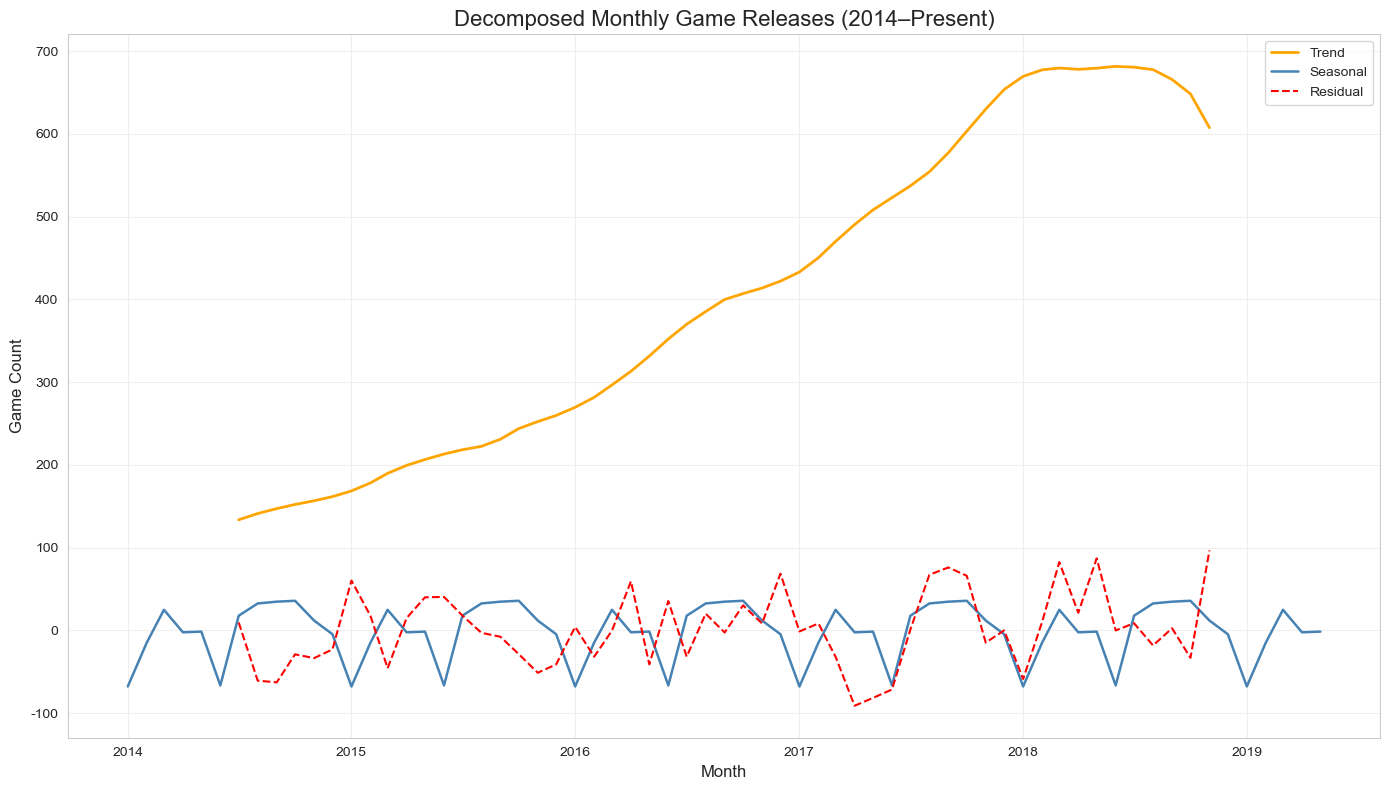

In [240]:
from statsmodels.tsa.seasonal import seasonal_decompose

ts = monthly_counts.set_index('month')['game_count']
decomposition = seasonal_decompose(ts, model='additive', period=12)  # period=12 对应一年

# 取季节成分
seasonal = decomposition.seasonal

#绘图

# 设置 seaborn 样式
sns.set_style("whitegrid")
plt.figure(figsize=(14, 8))

# 时间序列索引
ts_index = ts.index

# 绘制长期趋势
plt.plot(ts_index, decomposition.trend, color='orange', linewidth=2, label='Trend')

# 绘制季节性
plt.plot(ts_index, decomposition.seasonal, color='steelblue', linewidth=1.8, label='Seasonal')

# 绘制残差
plt.plot(ts_index, decomposition.resid, color='red', linestyle='--', linewidth=1.5, label='Residual')

# 显示
plt.title('Decomposed Monthly Game Releases (2014–Present)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Game Count', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

- 整体来看，Steam 平台的游戏发行量呈显著上升趋势，表明市场前景良好，为游戏公司选择该平台提供实证依据。
- 此外，时间序列表现出明显的短期周期性波动，提示发行商需合理安排发行节点，以降低直接竞争风险。

### 1.2 高产开发/发行商

近年高产开发商识别

/var/folders/dh/ldptd_p50b56gxq9cz8mf1nr0000gn/T/ipykernel_66750/3836724481.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dev_counts.values, y=dev_counts.index, palette="viridis")


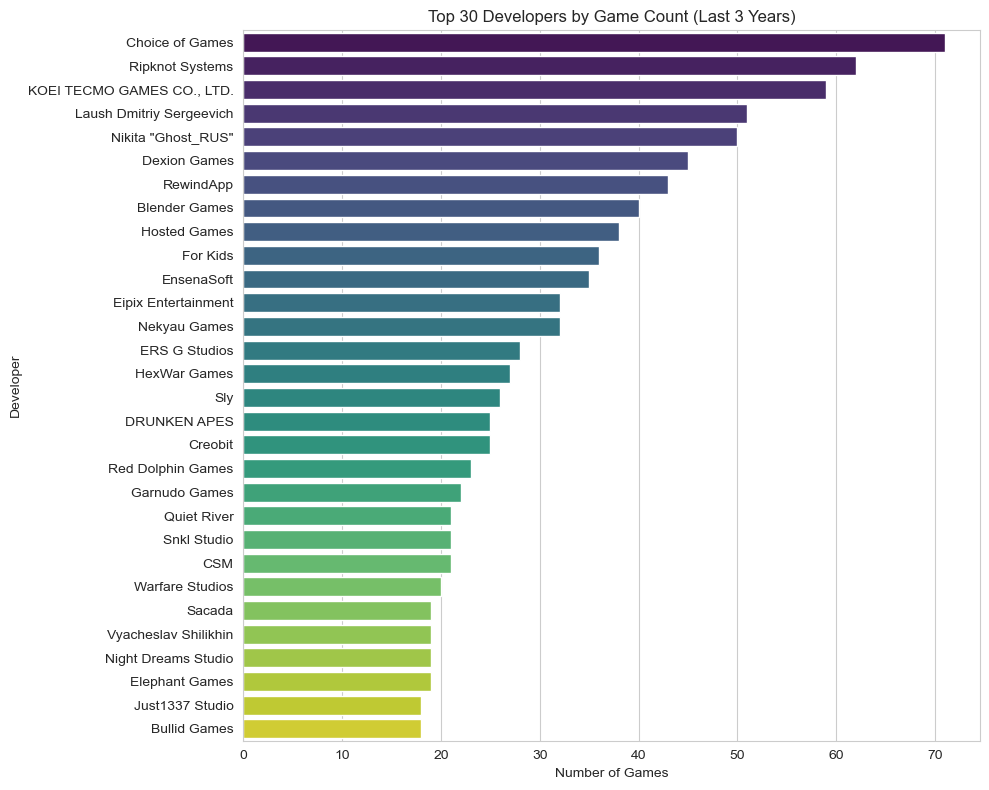

/var/folders/dh/ldptd_p50b56gxq9cz8mf1nr0000gn/T/ipykernel_66750/3836724481.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pub_counts.values, y=pub_counts.index, palette="magma")


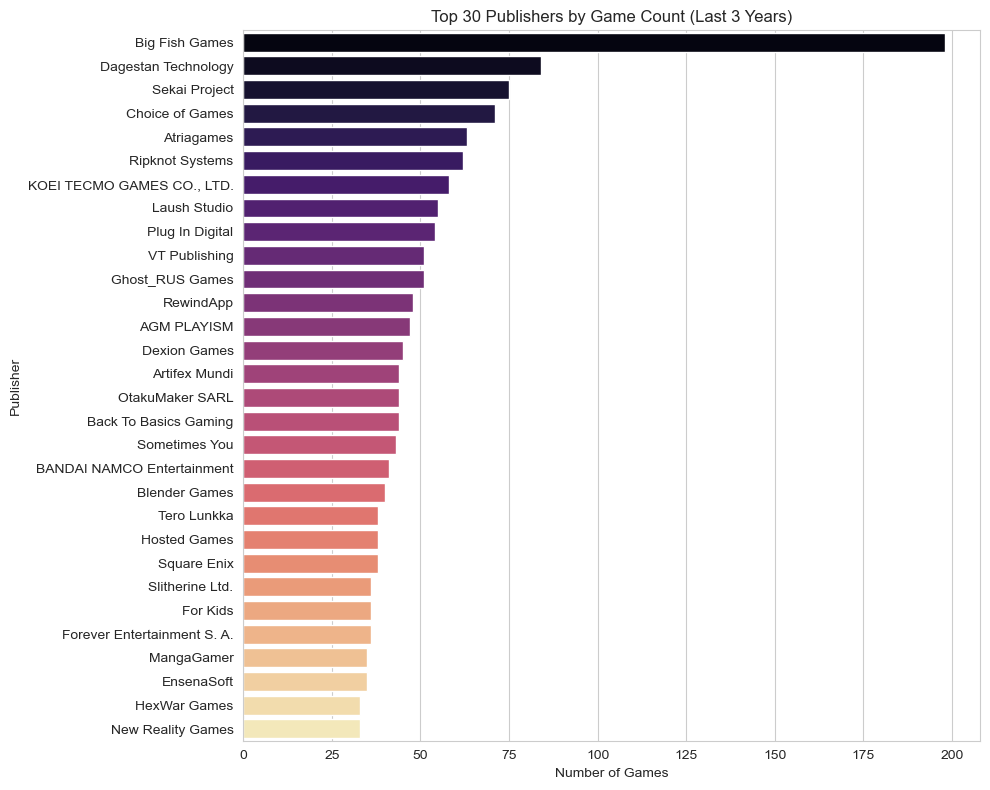

In [241]:
#取最后3年
start_year=2016
# -------------------------
# 1. 筛选最近3年数据
# -------------------------
steam_recent = steam[steam['release_date'].dt.year >= start_year]

# -------------------------
# 2. 统计开发商和发行商的游戏数量
# -------------------------
dev_counts = steam_recent['developer'].value_counts().head(30)
pub_counts = steam_recent['publisher'].value_counts().head(30)

# -------------------------
# 3. 绘制条形图
# -------------------------
plt.figure(figsize=(10,8))
sns.barplot(x=dev_counts.values, y=dev_counts.index, palette="viridis")
plt.title("Top 30 Developers by Game Count (Last 3 Years)")
plt.xlabel("Number of Games")
plt.ylabel("Developer")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,8))
sns.barplot(x=pub_counts.values, y=pub_counts.index, palette="magma")
plt.title("Top 30 Publishers by Game Count (Last 3 Years)")
plt.xlabel("Number of Games")
plt.ylabel("Publisher")
plt.tight_layout()
plt.show()

In [242]:
top30_devs = set(dev_counts.index)
top30_pubs = set(pub_counts.index)

# 交集
top30_dev_and_pub = top30_devs.intersection(top30_pubs)

print("前30名中既是开发商也是发行商的公司：")
for name in top30_dev_and_pub:
    print(name)

前30名中既是开发商也是发行商的公司：
For Kids
HexWar Games
Choice of Games
Dexion Games
Hosted Games
Ripknot Systems
EnsenaSoft
KOEI TECMO GAMES CO., LTD.
Blender Games
RewindApp


作用主要有三点：
- 市场格局洞察：识别行业头部玩家及其主导力量，掌握竞争集中度和市场结构。
- 合作与竞品参考：为游戏公司在选择合作伙伴或评估竞品策略提供参考依据。
- 趋势与策略指导：通过高产者的类型、发行节奏和标签偏好，辅助制定产品定位、定价及发行时间策略。

⚠️ 数据局限性说明：由于本数据集中缺乏这些开发商/发行商的更多背景信息及财务、市场数据，后两点的分析难以充分开展，仅能作为参考。

## 2 玩家拥有量分层洞察
由于数据中每款游戏仅包含发行时的属性与总体统计指标，而未追踪其随时间的变化，本分析提供的是跨游戏平均意义上的洞察。即可以比较不同属性组合下游戏的平均玩家量、平均玩时及好评率，但无法推断单个游戏的发行后动态趋势。
1. 市场格局洞察
	- 小众、腰部、头部游戏的数量、玩家量占比（required age）
	- 不同量级游戏的属性共性、差异
2. 策略指导
	- 判断目标用户规模 → 决定做小众/腰部/头部
	- 决定发行时间 → 避免竞争高峰期
	- 确定价格策略、配置要求、标签定位
3. 趋势预测 / 风险提示
	- 玩家量级结构变化趋势 → 市场容量、机会/风险
	- 观察新兴标签或热门类型 → 潜在头部游戏方向

**玩家拥有量分层分析指标体系**

| 维度         | 指标                         | 分层分析方法           | 目标                       |
|--------------|------------------------------|----------------------|----------------------------|
| 数量/玩家量  | 游戏数占比、玩家数占比        | 按小众/腰部/头部      | 市场结构洞察               |
| 标签         | Steam 标签频率 Top-N          | 分层统计             | 产品定位参考               |
| 价格         | 均价/中位价/折扣频次          | 分层统计             | 价格策略                   |
| 发行时间     | 年份、季度分布                | 分层统计             | 发布时间规划               |
| 评价         | 好评率、平均成就              | 分层统计             | 用户口碑分析               |
| 趋势         | 每类占比变化趋势              | 时间序列             | 市场预测 / 风险评估        |


**玩家拥有量分层 × 属性矩阵**

| 量级         | 游戏数占比 | 价格指标 | 发行时间分布 | Steam 标签频率 | 用户评价 | 用户粘性
|--------------|------------|------------|----------|--------------|----------|----------
| 小众 (<5 万) |            |            |          |              |                |          |          |
| 腰部 (5–100 万) |            |            |          |              |                |          |          |
| 头部 (>100 万) |            |            |          |              |                |          |          |

**指标说明**
- **游戏数占比**：每类游戏数量 / 总游戏数  
- **价格指标**：均价、中位价、折扣频次  
- **发行时间分布**：按年、季度或月份分布  
- **Steam 标签频率**：Top-N 标签占比  
- **用户评价**：好评率、平均成就数
- **用户粘性**：playtime

In [243]:
steam.owners.value_counts

<bound method IndexOpsMixin.value_counts of 0         5000000-10000000
1        10000000-20000000
2        10000000-20000000
3        10000000-20000000
4          2000000-5000000
               ...        
27059              0-20000
27060              0-20000
27061              0-20000
27062              0-20000
27063              0-20000
Name: owners, Length: 27064, dtype: object>

为了避免数值化带来的采样误差，直接按字符串区间进行排序计数

/var/folders/dh/ldptd_p50b56gxq9cz8mf1nr0000gn/T/ipykernel_66750/2652171936.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  steam['owners_left'] = steam['owners'].str.split('-').str[0].str.replace('+','0').astype(int)
/var/folders/dh/ldptd_p50b56gxq9cz8mf1nr0000gn/T/ipykernel_66750/2652171936.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  owners_counts['left_val'] = owners_counts['owners'].str.split('-').str[0].str.replace('+','0').astype(int)
/var/folders/dh/ldptd_p50b56gxq9cz8mf1nr0000gn/T/ipykernel_66750/2652171936.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and se

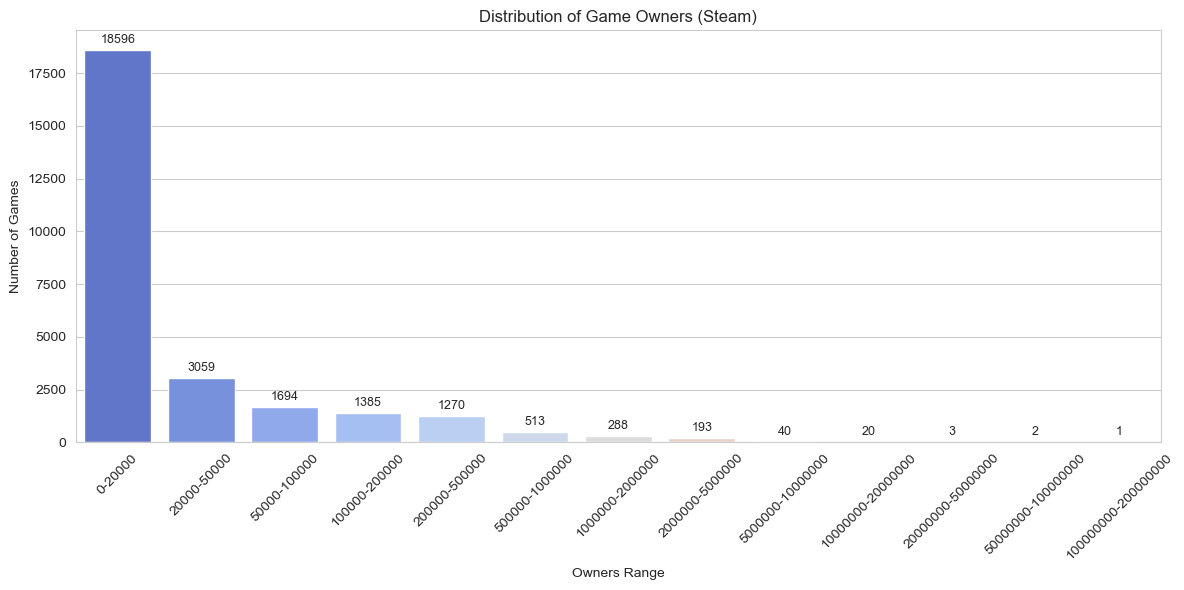

In [244]:
# 提取左端值
steam['owners_left'] = steam['owners'].str.split('-').str[0].str.replace('+','0').astype(int)

# 按左端值排序
owners_counts = steam.groupby('owners').size().reset_index(name='count')
owners_counts['left_val'] = owners_counts['owners'].str.split('-').str[0].str.replace('+','0').astype(int)
owners_counts = owners_counts.sort_values('left_val')

# 绘制条形图
plt.figure(figsize=(12,6))
ax = sns.barplot(x='owners', y='count', data=owners_counts, palette="coolwarm")
plt.xticks(rotation=45)
plt.xlabel("Owners Range")
plt.ylabel("Number of Games")
plt.title("Distribution of Game Owners (Steam)")

# 在每个条形上标记数字
for i, v in enumerate(owners_counts['count']):
    ax.text(i, v + max(owners_counts['count'])*0.01, str(v), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


In [245]:

# 提取左端值作为数值
steam['owners_left'] = steam['owners'].str.split('-').str[0].str.replace('+','0').astype(int)

# 筛选大于等于 20,000,000 的爆火游戏
high_owner_games = steam[steam['owners_left'] >= 20_000_000]

# 查看结果
high_owner_games[['name', 'owners', 'developer', 'publisher']]

/var/folders/dh/ldptd_p50b56gxq9cz8mf1nr0000gn/T/ipykernel_66750/3702871857.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  steam['owners_left'] = steam['owners'].str.split('-').str[0].str.replace('+','0').astype(int)


,name,owners,developer,publisher
12,Team Fortress 2,20000000-50000000,Valve,Valve
15,Dota 2,100000000-200000000,Valve,Valve
18,Counter-Strike: Global Offensive,50000000-100000000,Valve;Hidden Path Entertainment,Valve
1624,Warframe,20000000-50000000,Digital Extremes,Digital Extremes
3351,Unturned,20000000-50000000,Smartly Dressed Games,Smartly Dressed Games
12825,PLAYERUNKNOWN'S BATTLEGROUNDS,50000000-100000000,PUBG Corporation,PUBG Corporation


随着拥有者数目的增长，游戏数目不断降低。近八成（的游戏拥有者数目处在[0, 50000]

其中，个别游戏如Team Fortress 2, Dota 2, Counter-Strike: Global Offensive, Warframe, Unturned, PLAYERUNKNOWN'S BATTLEGROUNDS玩家数超过两千万，属于顶级爆款游戏

不同游戏的价格分布趋势：取对数（对数均值“低估”原始均值，解释为“价格的几何平均水平”，相比算术平均更稳健）

/var/folders/dh/ldptd_p50b56gxq9cz8mf1nr0000gn/T/ipykernel_66750/3416350741.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  steam['owners_left'] = steam['owners'].str.split('-').str[0].str.replace('+','0').astype(int)


/var/folders/dh/ldptd_p50b56gxq9cz8mf1nr0000gn/T/ipykernel_66750/3416350741.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='owners', y=np.log1p(steam['price']), data=steam, order=owners_order, palette="Set3")


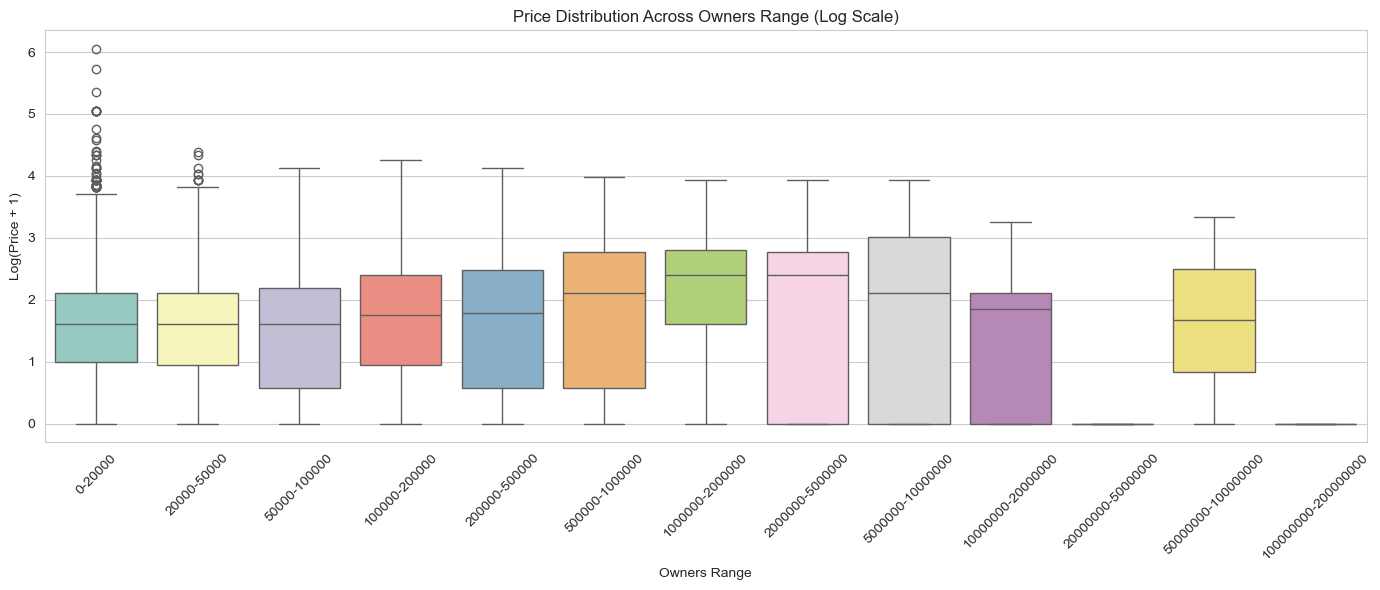

<Figure size 800x600 with 0 Axes>

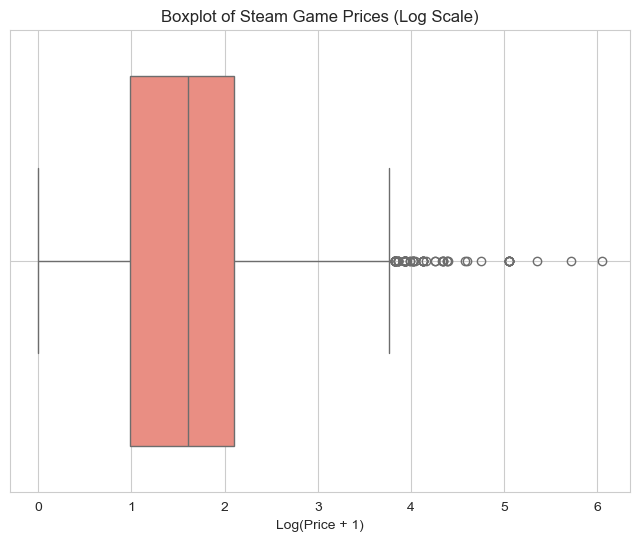

count    27064.000000
mean         6.078879
std          7.876284
min          0.000000
25%          1.690000
50%          3.990000
75%          7.190000
max        421.990000
Name: price, dtype: float64

In [246]:
steam['owners_left'] = steam['owners'].str.split('-').str[0].str.replace('+','0').astype(int)

# 按 owners 左端值排序区间
owners_order = steam.groupby('owners')['owners_left'].min().sort_values().index

plt.figure(figsize=(14,6))

#削弱极端价格影响，取对数价格
sns.boxplot(x='owners', y=np.log1p(steam['price']), data=steam, order=owners_order, palette="Set3")
plt.xticks(rotation=45)
plt.xlabel("Owners Range")
plt.ylabel("Log(Price + 1)")
plt.title("Price Distribution Across Owners Range (Log Scale)")
plt.tight_layout()
plt.show()


plt.figure(figsize=(8,6))
# 对数价格箱线图 (可选)
plt.figure(figsize=(8,6))
sns.boxplot(x=np.log1p(steam['price']), color='salmon')
plt.xlabel("Log(Price + 1)")
plt.title("Boxplot of Steam Game Prices (Log Scale)")
plt.grid(True)
plt.show()
steam['price'].describe()

统计每组均值

/var/folders/dh/ldptd_p50b56gxq9cz8mf1nr0000gn/T/ipykernel_66750/3663771556.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  steam['owners_left'] = steam['owners'].str.split('-').str[0].str.replace('+','0').astype(int)


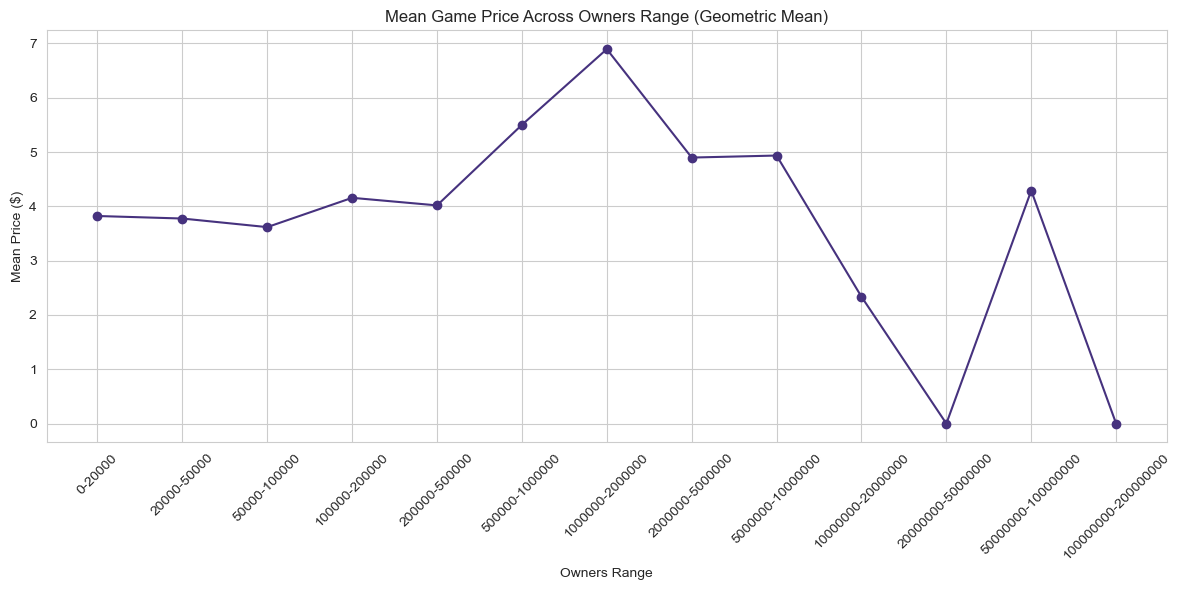

In [247]:

from scipy.stats import gmean

# 提取区间左值排序
steam['owners_left'] = steam['owners'].str.split('-').str[0].str.replace('+','0').astype(int)
owners_order = steam.groupby('owners')['owners_left'].min().sort_values().index

# 计算每个 owners 区间的几何均值（对数均值反变换）
grouped = steam.groupby('owners')['price'].apply(lambda x: np.expm1(np.log1p(x).mean())).reindex(owners_order)

# 绘制折线图
plt.figure(figsize=(12,6))
plt.plot(grouped.index, grouped.values, marker='o')
plt.xticks(rotation=45)
plt.xlabel("Owners Range")
plt.ylabel("Mean Price ($)")
plt.title("Mean Game Price Across Owners Range (Geometric Mean)")
plt.grid(True)
plt.tight_layout()
plt.show()


截至 2019 年，Steam 平台游戏价格分布呈明显偏低趋势：整体价格中位数为 3.99 美元，均值约 6.08 美元，大部分游戏价格集中在 1.69–7.19 美元区间（见箱线图）。分析玩家拥有量后发现：

- **低价游戏（≤7 美元）** 平均玩家数显著高于高价游戏，甚至部分免费游戏拥有者数超过百万，显示低价策略有助于快速扩展用户群。
- **高价游戏（>20 美元）** 平均玩家数明显下降，部分玩家稀少的高价游戏可能并非质量不足，而是定价过高导致潜在玩家难以负担。
- 分层分析显示：小众游戏、中等玩家量游戏和头部游戏的价格分布存在差异，小众游戏价格偏高或折扣有限，腰部和头部游戏价格更贴近市场主流。

**策略启示**：

- 开发/发行者在平衡成本和收益的前提下，应考虑定价对用户规模的影响。合理的中低价格区间可帮助新游戏快速吸引玩家，提高市场渗透率。
- 对于小众高价游戏，可以通过折扣、促销或免费策略提高初期玩家量，从而提升口碑和长期收益。
- 不同玩家群体和游戏类型的价格策略应分层制定，而非简单“一刀切”降低价格。


分组发行量时间序列

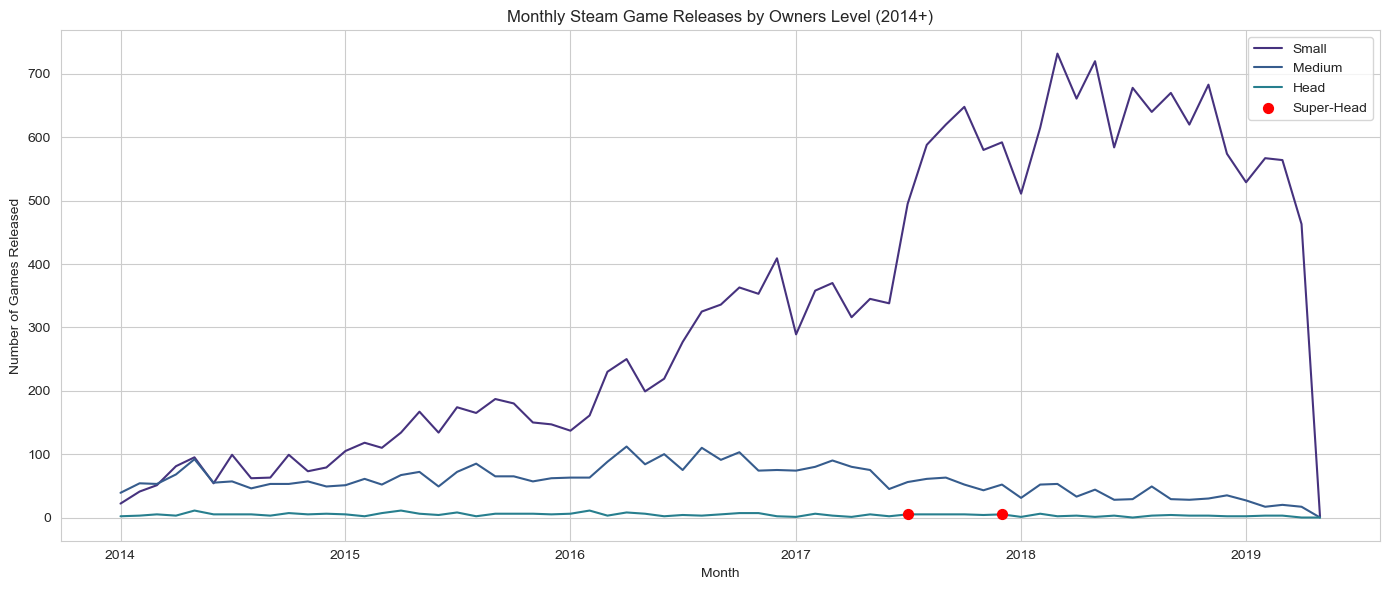

In [248]:
# 只保留 2014 年及以后的数据
steam['release_date'] = pd.to_datetime(steam['release_date'])
steam_after_2014 = steam[steam['release_date'].dt.year >= 2014].copy()


steam_after_2014['month'] = steam_after_2014['release_date'].dt.to_period('M')

# 定义分层（Super-Head 不单独线）
def owners_level(owners_str):
    left = int(owners_str.split('-')[0].replace('+','0'))
    if left < 50000:
        return 'Small'
    elif left < 1000000:
        return 'Medium'
    else:
        return 'Head'  # 头部包含 Super-Head

steam_after_2014['owners_level'] = steam_after_2014['owners'].apply(owners_level)

# 月度分组统计
monthly_counts = steam_after_2014.groupby(['month', 'owners_level']).size().unstack(fill_value=0)

# 找出 Super-Head 游戏对应月份
super_head_months = steam_after_2014[steam_after_2014['owners'].apply(lambda x: int(x.split('-')[0].replace('+','0')) >= 20000000)]
super_head_counts = super_head_months.groupby('month').size()

# 绘图
plt.figure(figsize=(14,6))
for level in ['Small','Medium','Head']:
    plt.plot(monthly_counts.index.to_timestamp(), monthly_counts[level], label=level)

# 在 Head 线圈出 Super-Head 游戏点
for month, count in super_head_counts.items():
    if month in monthly_counts.index:
        head_value = monthly_counts.loc[month, 'Head']
        plt.scatter(month.to_timestamp(), head_value, color='red', s=50, zorder=5, label='Super-Head' if month==super_head_counts.index[0] else "")

plt.xlabel("Month")
plt.ylabel("Number of Games Released")
plt.title("Monthly Steam Game Releases by Owners Level (2014+)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

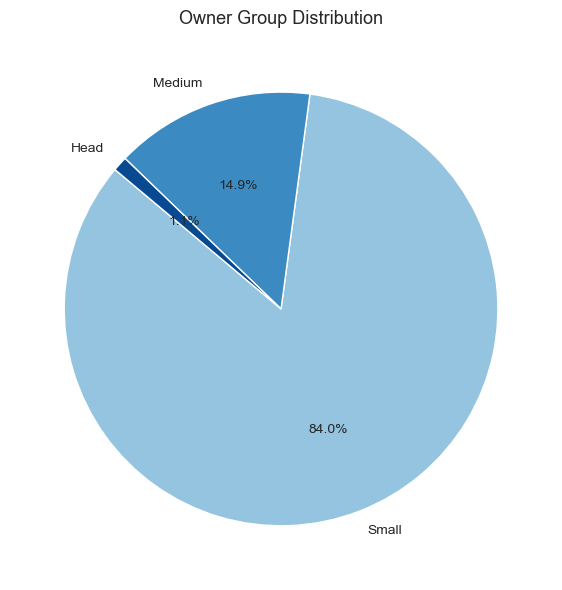

In [249]:
import matplotlib.pyplot as plt

# 统计 owner_group 各类别数量
group_counts = steam_after_2014['owners_level'].value_counts()

# 设置颜色调色盘
colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(group_counts)))

# 画饼状图
plt.figure(figsize=(6, 6))
plt.pie(
    group_counts,
    labels=group_counts.index,
    autopct='%1.1f%%',    # 显示百分比
    startangle=140,       # 起始角度
    colors=colors,
    textprops={'fontsize': 10}
)

plt.title('Owner Group Distribution', fontsize=13, pad=10)
plt.tight_layout()
plt.show()

假设：头部（Head）、腰部（Medium）、小众（Small）游戏的价格分布没有显著差异。

说明：
- 为保证每组样本量足够，本次分析未对极端价格值做严格界定，因此可能存在少量异常高价或低价游戏。
- 该假设关注的是总体均值或中位数的比较，而不是极端个例。
- 检验结果若不显著，并不意味着各类型游戏价格完全相同，只说明在样本统计范围内没有明显系统性差异。
- 可通过可视化（箱线图、均值折线图）或效应量（均值差、百分比差）补充解释实际差异大小和市场策略参考价值。

Small     21655
Medium     4862
Head        547
Name: owner_group, dtype: int64


/var/folders/dh/ldptd_p50b56gxq9cz8mf1nr0000gn/T/ipykernel_66750/1979313713.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='owner_group', y=np.log1p(steam['price']), data=steam, palette='Set2')


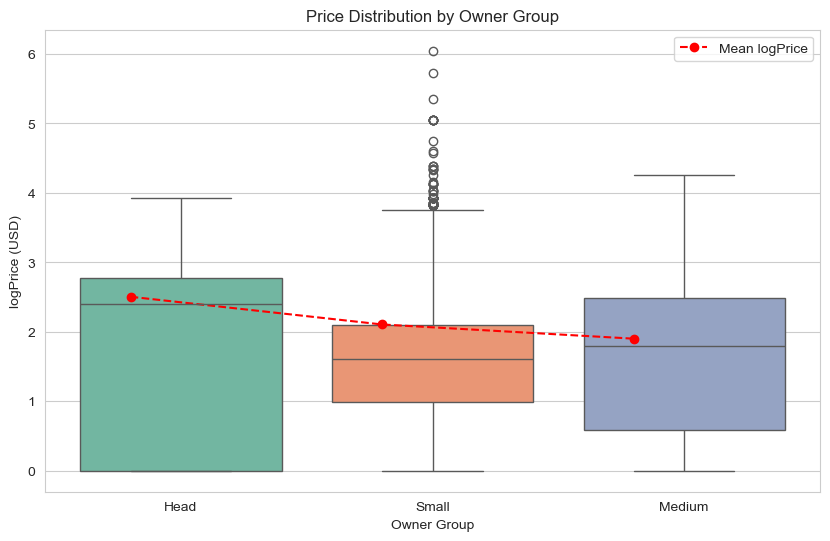

Kruskal-Wallis H-statistic: 118.719, p-value: 0.000
结论：不同玩家量组游戏价格存在显著差异


In [250]:

from scipy.stats import kruskal

# 分组定义
def categorize_owners(owners):
    # 用左值判断
    left_val = owners.split('-')[0].replace(',', '')
    left_val = int(left_val)
    if left_val < 50000:
        return 'Small'
    elif left_val < 1000000:
        return 'Medium'
    else:
        return 'Head'

steam['owner_group'] = steam['owners'].apply(categorize_owners)

# 查看每组样本量
print(steam['owner_group'].value_counts())

# 绘制箱型图 + 平均值折线
plt.figure(figsize=(10,6))
sns.boxplot(x='owner_group', y=np.log1p(steam['price']), data=steam, palette='Set2')
group_means = steam.groupby('owner_group')['price'].mean()
group_means_log = np.log1p(group_means)

plt.plot([-0.2,0.8,1.8], group_means_log.values, color='red', marker='o', linestyle='--', label='Mean logPrice')
plt.xlabel('Owner Group')
plt.ylabel('logPrice (USD)')
plt.title('Price Distribution by Owner Group')
plt.legend()
plt.show()

# 非参数检验（Kruskal-Wallis）
groups = [steam[steam['owner_group']==g]['price'] for g in ['Small','Medium','Head']]
stat, p = kruskal(*groups)
print(f"Kruskal-Wallis H-statistic: {stat:.3f}, p-value: {p:.3f}")

if p < 0.05:
    print("结论：不同玩家量组游戏价格存在显著差异")
else:
    print("结论：不同玩家量组游戏价格差异不显著")

- 超级头部缺失：截至 2019 年 5 月 1 日，Steam 平台近 18 个月内未出现超级头部游戏（玩家拥有量 ≥ 2,000 万），显示顶级爆款游戏短期缺位。
- 腰部游戏趋势：与 2017 年及以前相比，中等玩家量游戏（腰部游戏）发行量呈下降趋势，尽管存在季节性小幅波动。
- 小众游戏趋势：小众游戏（玩家拥有量 < 5 万）发行量整体上升，同时保持显著季节性波动，高峰主要集中在春季和秋季，但最近 6 个月呈现下降。
- 头部游戏价格特征：头部游戏价格波动剧烈，多次出现极端值（如 2019 年部分月份价格突破 40 美元），整体均价显著高于中腰部和小众游戏，反映其定价策略灵活、溢价能力强，可能受大作发行和限时高价策略影响。
- 中腰部与小众游戏价格特征：价格走势相对平稳，长期均值保持在 5–10 美元区间，显示中腰部和小众游戏定价更趋保守，以稳定价格吸引目标玩家群体。
- 层级差异与市场效应：头部游戏与中腰部、小众游戏价格区间明显分层，体现 Steam 平台的“定价分层效应”——玩家规模越大，价格自由度与溢价空间越高；中小规模游戏则在价格上形成相对固定的竞争区间。


### 热门标签

In [251]:
import pandas as pd

# 1. 拆分三列
def split_and_aggregate(row):
    tags = set()  # 用 set 去重
    for col in ['categories', 'genres', 'steamspy_tags']:
        if pd.notna(row[col]):
            # 分号分割，去除空白
            items = [x.strip() for x in row[col].split(';') if x.strip()]
            tags.update(items)
    return ';'.join(sorted(tags))  # 可以用分号连接，也可以用列表

# 2. 生成新的标签列
steam['tags_aggregated'] = steam.apply(split_and_aggregate, axis=1)

# 3. 查看效果
steam[['name', 'categories', 'genres', 'steamspy_tags', 'tags_aggregated']].head()

,name,categories,genres,steamspy_tags,tags_aggregated
0,Day of Defeat,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,Action;FPS;Multi-player;Multiplayer;Valve Anti...
1,Counter-Strike: Condition Zero,Single-player;Multi-player;Valve Anti-Cheat en...,Action,Action;FPS;Multiplayer,Action;FPS;Multi-player;Multiplayer;Single-pla...
2,Half-Life 2,Single-player;Steam Achievements;Steam Trading...,Action,FPS;Action;Sci-fi,Action;Captions available;FPS;Includes Source ...
3,Counter-Strike: Source,Multi-player;Cross-Platform Multiplayer;Steam ...,Action,Action;FPS;Multiplayer,Action;Cross-Platform Multiplayer;FPS;Includes...
4,Half-Life: Source,Single-player,Action,FPS;Action;Sci-fi,Action;FPS;Sci-fi;Single-player


In [252]:

from collections import Counter

# 1. 拆分标签列成列表
all_tags = steam['tags_aggregated'].dropna().str.split(';')

# 2. 扁平化所有标签
flat_tags = [tag.strip() for sublist in all_tags for tag in sublist if tag.strip()]

# 3. 统计出现次数
tag_counts = Counter(flat_tags)

# 4. 转成 DataFrame 并排序
tag_counts_df = pd.DataFrame(tag_counts.items(), columns=['tag', 'count']).sort_values(by='count', ascending=False)

/var/folders/dh/ldptd_p50b56gxq9cz8mf1nr0000gn/T/ipykernel_66750/3606238057.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='tag', data=top_tags, palette='viridis')


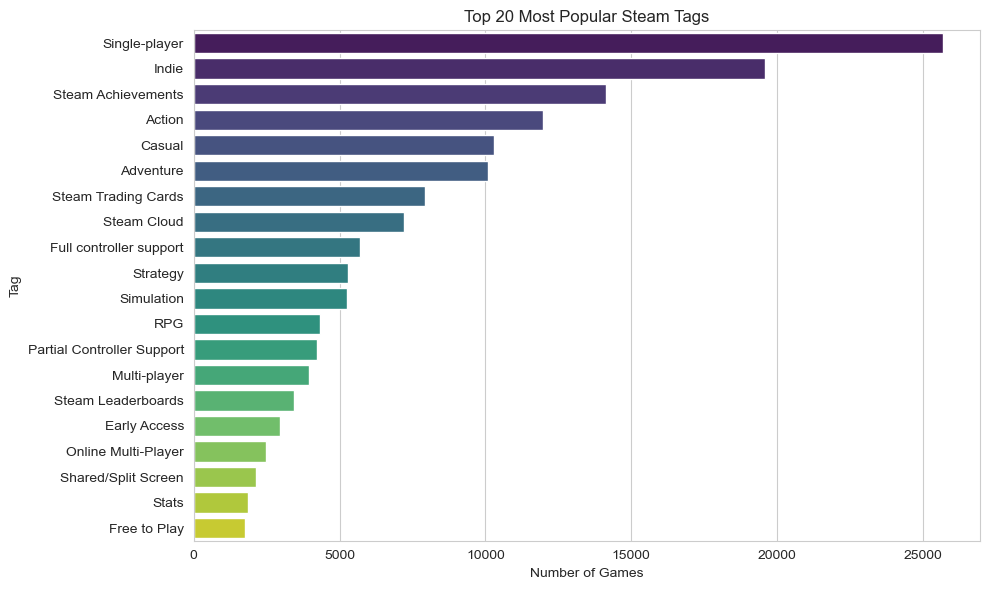

In [253]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置风格
sns.set_style("whitegrid")

# 选择最热门前20标签
top_tags = tag_counts_df.head(20)

# 水平条形图
plt.figure(figsize=(10,6))
sns.barplot(x='count', y='tag', data=top_tags, palette='viridis')
plt.xlabel('Number of Games')
plt.ylabel('Tag')
plt.title('Top 20 Most Popular Steam Tags')
plt.tight_layout()
plt.show()

### 分组评价情况以及用户粘性

大量游戏平均玩时和玩时中位数为0，应当剔除

/var/folders/dh/ldptd_p50b56gxq9cz8mf1nr0000gn/T/ipykernel_66750/518863948.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/dh/ldptd_p50b56gxq9cz8mf1nr0000gn/T/ipykernel_66750/518863948.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/dh/ldptd_p50b56gxq9cz8mf1nr0000gn/T/ipykernel_66750/518863948.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


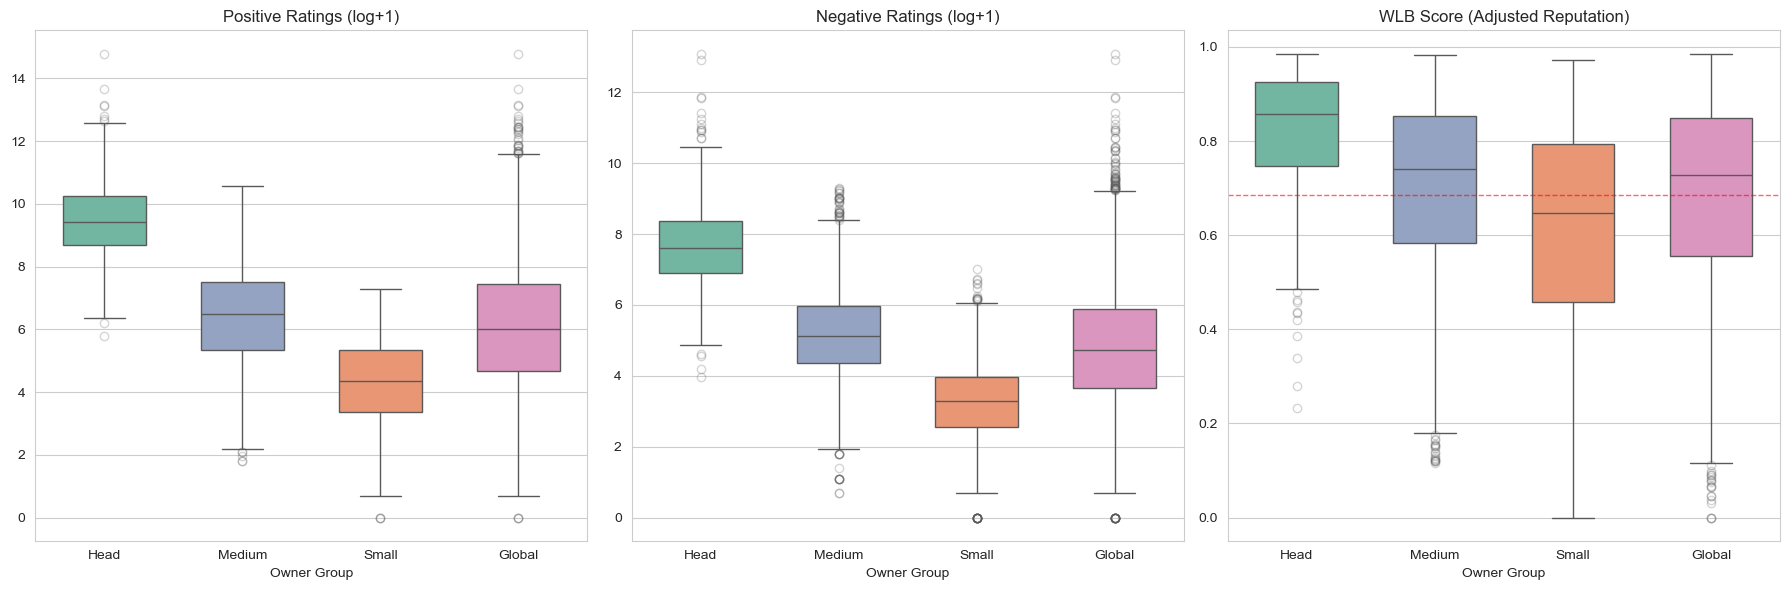

In [254]:

from scipy.stats import norm

# ========== 数据预处理 ==========
# 临时过滤掉平均/中位游玩时长为0的游戏
df = steam[(steam['average_playtime'] > 0) & (steam['median_playtime'] > 0)].copy()

# 计算 log 转换后的评价数
df['log_positive'] = np.log1p(df['positive_ratings'])
df['log_negative'] = np.log1p(df['negative_ratings'])
df['total_ratings'] = df['positive_ratings'] + df['negative_ratings']

# 定义 Wilson 下界函数
def wilson_lower_bound(pos, total, conf=0.95):
    if total == 0:
        return 0
    p = pos / total
    z = norm.ppf((1 + conf) / 2)
    denom = 1 + z**2 / total
    adj = (p + z**2 / (2 * total)) / denom
    margin = z * np.sqrt(p * (1 - p) / total + z**2 / (4 * total**2)) / denom
    return adj - margin

df['wlb_score'] = df.apply(lambda r: wilson_lower_bound(r['positive_ratings'], r['total_ratings']), axis=1)

# ========== 数据组装 ==========
def make_boxdata(df, col):
    tmp = df[['owner_group', col]].rename(columns={col: 'value'})
    global_data = pd.DataFrame({'owner_group': 'Global', 'value': df[col]})
    return pd.concat([tmp, global_data], ignore_index=True)

data_map = {
    'Positive Ratings (log+1)': make_boxdata(df, 'log_positive'),
    'Negative Ratings (log+1)': make_boxdata(df, 'log_negative'),
    'WLB Score (Adjusted Reputation)': make_boxdata(df, 'wlb_score')
}

# ========== 绘图 ==========
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
colors = ['#66c2a5', '#8da0cb', '#fc8d62', '#e78ac3', '#a6d854']

for ax, (title, data) in zip(axes, data_map.items()):
    sns.boxplot(
        data=data, x='owner_group', y='value',
        palette=colors[:data['owner_group'].nunique()], width=0.6,
        flierprops={'alpha': 0.25}, ax=ax,
    )
    ax.set_title(title)
    ax.set_xlabel('Owner Group')
    ax.set_ylabel('')
    if 'WLB' in title:
        ax.axhline(y=df['wlb_score'].mean(), color='red', ls='--', lw=1, alpha=0.6)

plt.tight_layout()
plt.show()

假设检验：不同玩家基数的组之间好评率wlb分数是否有显著差异（零假设：无显著差异）

In [255]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, levene, f_oneway, kruskal, mannwhitneyu
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests

def compare_groups(df, group_col, value_col, groups=('Small','Medium','Head'), alpha=0.05):
    df = df[df[group_col].isin(groups)].copy()
    group_data = [df[df[group_col]==g][value_col] for g in groups]
    
    # --- 描述性统计 ---
    desc = df.groupby(group_col)[value_col].agg(['count','mean','std']).round(3)
    print("📊 基本统计：\n", desc, "\n")

    # --- 前提检验 ---
    def safe_shapiro(x):
        x = x.sample(min(len(x), 5000), random_state=42)
        return shapiro(x)[1]
    norm_p = [safe_shapiro(x) for x in group_data]
    lev_p = levene(*group_data)[1]
    norm_pass = all(p > alpha for p in norm_p)
    homo = lev_p > alpha

    # --- 主检验 ---
    if norm_pass and homo:
        stat, p = f_oneway(*group_data)
        method = "单因素ANOVA"
    else:
        stat, p = kruskal(*group_data)
        method = "Kruskal-Wallis"
    print(f"🔍 {method} 检验结果: stat={stat:.3f}, p={p:.6f}")
    print("→ 显著差异" if p < alpha else "→ 无显著差异", "\n")

    # --- 事后检验 ---
    if p < alpha:
        print("🎯 事后比较：")
        if method == "单因素ANOVA":
            res = pairwise_tukeyhsd(df[value_col], df[group_col], alpha=alpha)
            print(res.summary())
        else:
            pairs = [(groups[i], groups[j]) for i in range(len(groups)) for j in range(i+1,len(groups))]
            results = []
            for g1,g2 in pairs:
                u, p_raw = mannwhitneyu(df[df[group_col]==g1][value_col], df[df[group_col]==g2][value_col])
                results.append((f"{g1} vs {g2}", p_raw))
            adj_p = multipletests([p for _,p in results], method='bonferroni')[1]
            for (pair,_), p_corr in zip(results, adj_p):
                sig = "✅" if p_corr < alpha else "❌"
                print(f"{pair}: p_adj={p_corr:.6f} {sig}")

# === 使用示例 ===
compare_groups(df, 'owner_group', 'wlb_score')

📊 基本统计：
              count   mean    std
owner_group                     
Head           545  0.822  0.129
Medium        3796  0.700  0.190
Small         1819  0.615  0.218 

🔍 Kruskal-Wallis 检验结果: stat=500.439, p=0.000000
→ 显著差异 

🎯 事后比较：
Small vs Medium: p_adj=0.000000 ✅
Small vs Head: p_adj=0.000000 ✅
Medium vs Head: p_adj=0.000000 ✅



Steam 游戏市场的口碑分布呈现明显的 “玩家基数分层效应”：玩家基数越大，口碑（经修正后）越好、越稳定。这种分层本质是 “品质筛选 + 规模效应 + 玩家分化” 共同作用的结果 —— 头部游戏靠品质和规模形成口碑壁垒，腰部游戏在竞争中寻求稳定，小众游戏则因品质参差不齐和样本量偏差导致口碑两极分化。
整体而言，玩家基数提升有助于提升好评率。

游戏价格与评分的相关性

/var/folders/dh/ldptd_p50b56gxq9cz8mf1nr0000gn/T/ipykernel_66750/1220653315.py:20: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.scatterplot(


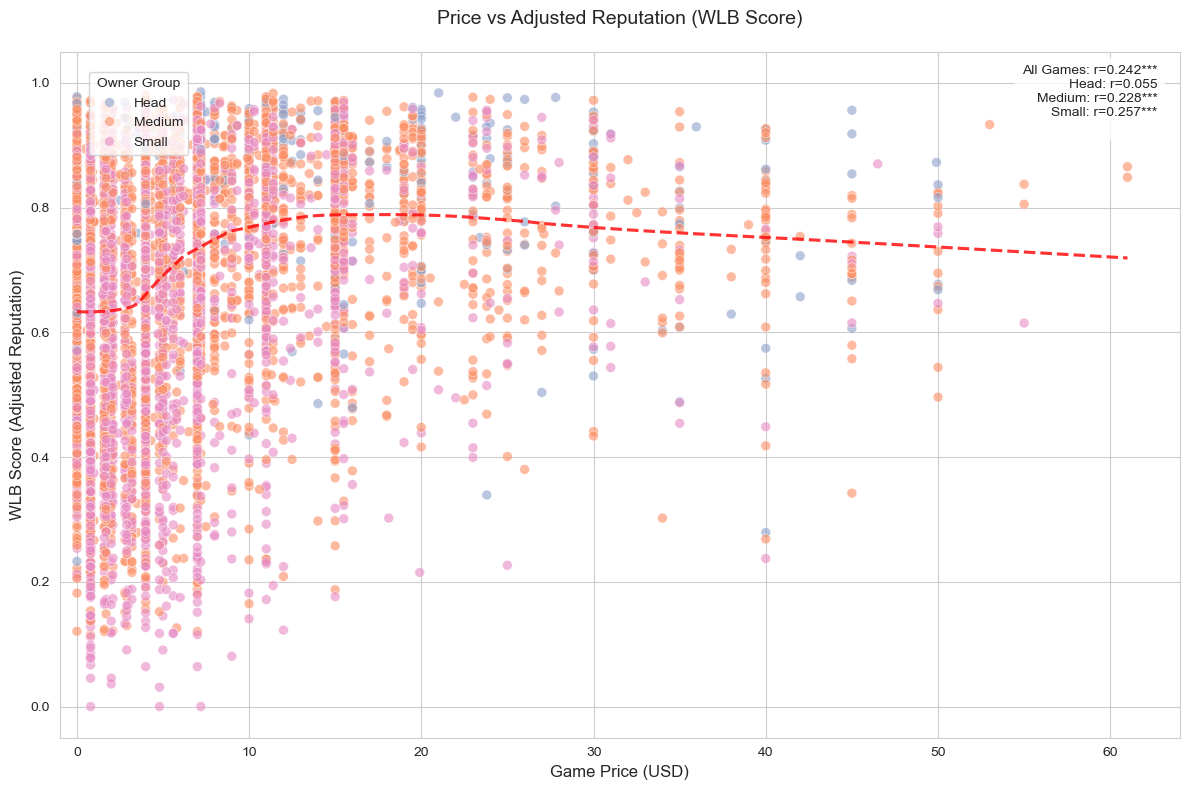

In [256]:
from scipy.stats import pearsonr

# 使用过滤后的 df
df_plot = df[(df['price'] >= 0) & (df['price'] <= 100)].copy()  # 可根据实际情况调整价格范围

# ---------------------- 计算相关系数 ----------------------
def calc_corr(df, group_col='owner_group'):
    results = [('All Games', *pearsonr(df['price'], df['wlb_score']))]
    for g, gdf in df.groupby(group_col):
        if len(gdf) >= 30:
            results.append((g, *pearsonr(gdf['price'], gdf['wlb_score'])))
    return results

corr_results = calc_corr(df_plot)

# ---------------------- 绘制散点图 ----------------------
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=df_plot,
    x='price',
    y='wlb_score',
    hue='owner_group',
    palette=['#8da0cb', '#fc8d62', '#e78ac3', '#a6d854'],
    alpha=0.6,
    s=50,
    edgecolor='white',
    linewidth=0.5
)

# 整体 LOWESS 趋势线
sns.regplot(
    data=df_plot,
    x='price',
    y='wlb_score',
    scatter=False,
    color='red',
    line_kws={'linestyle': '--', 'alpha':0.8},
    lowess=True
)

# ---------------------- 添加相关系数标注 ----------------------
text = ""
for group, corr, p in corr_results:
    sig = "***" if p<0.001 else "**" if p<0.01 else "*" if p<0.05 else ""
    text += f"{group}: r={corr:.3f}{sig}\n"

plt.annotate(
    text,
    xy=(0.98, 0.98), xycoords='axes fraction',
    ha='right', va='top',
    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8),
    fontsize=10
)

# ---------------------- 美化与标签 ----------------------
plt.xlabel('Game Price (USD)', fontsize=12)
plt.ylabel('WLB Score (Adjusted Reputation)', fontsize=12)
plt.title('Price vs Adjusted Reputation (WLB Score)', fontsize=14, pad=20)
plt.legend(title='Owner Group', bbox_to_anchor=(0.02,0.98), loc='upper left')
plt.xlim(-1, df_plot['price'].max()*1.05)
plt.ylim(-0.05, 1.05)
plt.tight_layout()
plt.show()

- 散点图整体较为分散，且数据集中于小价格区间，高价游戏样本占比低
    - 整体来看，游戏价格与调整后声誉呈显著弱正相关，不同层级游戏关联强度存在差异：小众游戏（Small: r=0.268***）> 腰部游戏（Medium: r=0.243***）> 头部游戏（Head: r=0.203***），均通过统计显著性检验（p<0.001）。
    - 高价游戏的高评价并非源于价格本身，核心是 “价格筛选目标用户 + 品质匹配预期 + 策略兑现价值” 三者协同作用的结果。
    - 分层特征表明：小众游戏价格与声誉联动性最强，头部游戏因品牌 / 生态壁垒，价格对声誉的直接影响相对最弱。
    
    以上关系在小价格区间（20美元以下较为可信）

高价游戏的高评价并非一定是 “价格本身带来好评”，更可能是 **“价格筛选用户 + 品质匹配预期 + 策略兑现价值”** 三者共同作用的结果

游戏玩时/用户粘性分析

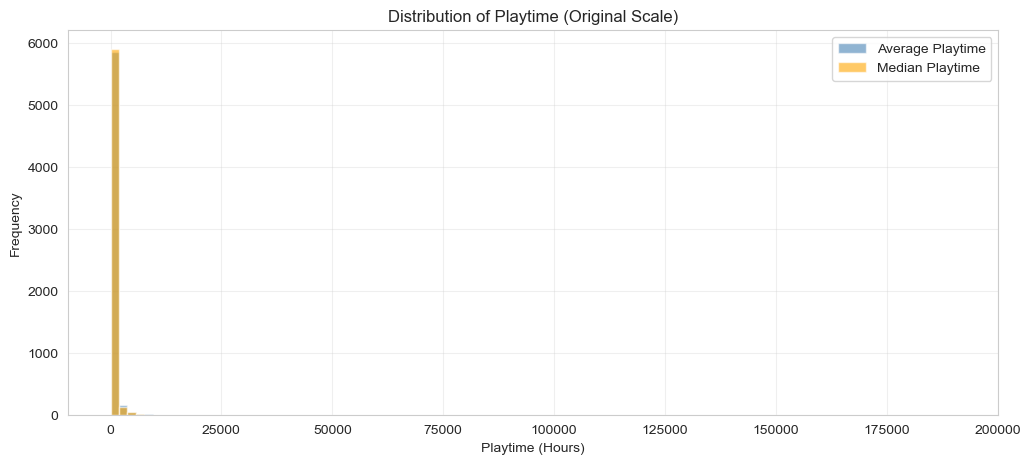

In [257]:
# 原尺度分布（不对数变换）
plt.figure(figsize=(12, 5))

# 使用对数坐标 x 轴，保留原值分布，避免长尾影响可视化
plt.hist(df['average_playtime'], bins=100, alpha=0.6, label='Average Playtime', color='steelblue')
plt.hist(df['median_playtime'], bins=100, alpha=0.6, label='Median Playtime', color='orange')

plt.title('Distribution of Playtime (Original Scale)')
plt.xlabel('Playtime (Hours)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(alpha=0.3)

# 可选：使用对数 x 轴，更好显示长尾分布
# plt.xscale('log')
# plt.xlabel('Playtime (Minutes, Log-Scale)')

plt.show()

数据长尾分布明显，不利于后续的建模分析；取对数

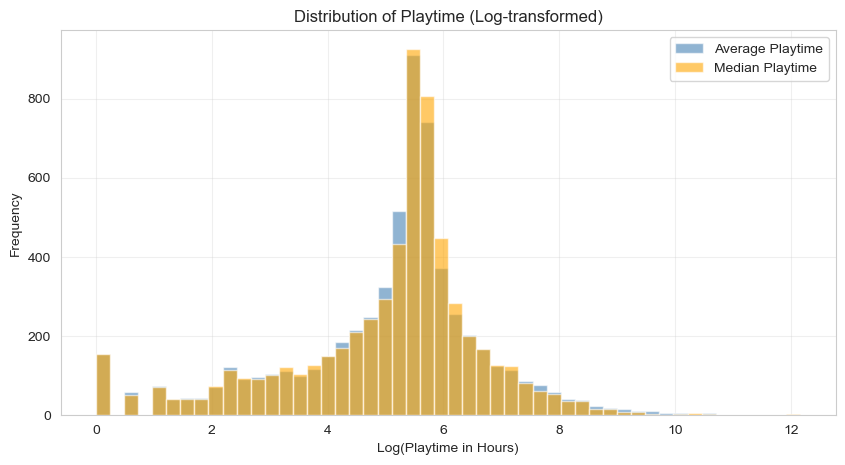

(6160, 28)


In [258]:
# 对数变换（自然对数）
df['log_avg'] = np.log(df['average_playtime'])
df['log_median'] = np.log(df['median_playtime'])

# 绘图
plt.figure(figsize=(10, 5))
plt.hist(df['log_avg'], bins=50, alpha=0.6, label='Average Playtime', color='steelblue')
plt.hist(df['log_median'], bins=50, alpha=0.6, label='Median Playtime', color='orange')
plt.title('Distribution of Playtime (Log-transformed)')
plt.xlabel('Log(Playtime in Hours)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(df.shape)

由于指示用户粘性的其他数据难以获取，此处仅以平均玩时和中位数加权平均，因为已经对数变换，二者分布几乎重合，故等比例分配

In [259]:
from sklearn.preprocessing import MinMaxScaler

# 标准化 log_avg 和 log_median：0-1 标准化，便于横向比较
scaler = MinMaxScaler()
df[['log_avg_norm', 'log_med_norm']] = scaler.fit_transform(df[['log_avg', 'log_median']])

# 生成基础粘性指标（平均两者）
df['stickiness'] = 0.5*df['log_avg_norm'] + 0.5*df['log_med_norm']

# 查看前几行
df[['log_avg', 'log_median', 'stickiness']].head()

,log_avg,log_median,stickiness
0,5.231109,3.526361,0.360151
1,6.056784,3.761200,0.403764
2,6.538140,5.996452,0.515485
3,8.830835,5.991465,0.609567
4,5.247024,5.365976,0.436459


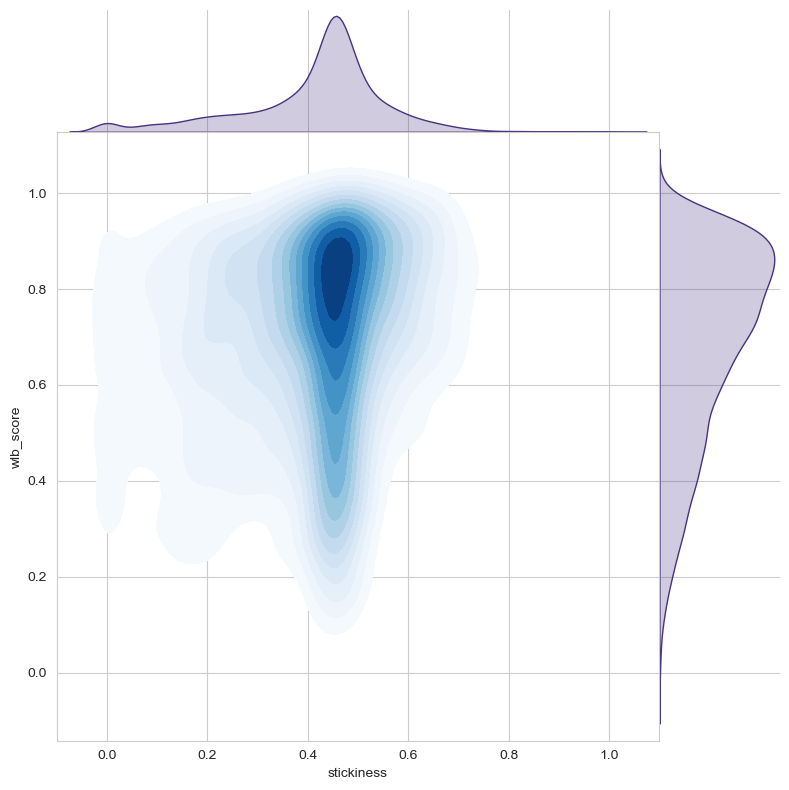

In [260]:
sns.set_style("whitegrid")
sns.jointplot(
    data=df,
    x='stickiness',
    y='wlb_score',
    kind='kde',
    height=8,
    space=0,
    cmap ='Blues',
    fill =True,
    levels=15
)

In [261]:
#拷贝数据回 steam 主数据集
steam['stickiness'] = df['stickiness']
steam['stickiness'].fillna(0, inplace=True)

大量游戏因为用户玩时为0，聚集在左侧，但是对于玩时少的游戏，用户评分依然多样化，此外，其他游戏集中在右上角，说明粘性和评分均较高

## 3 平台市场价值评估

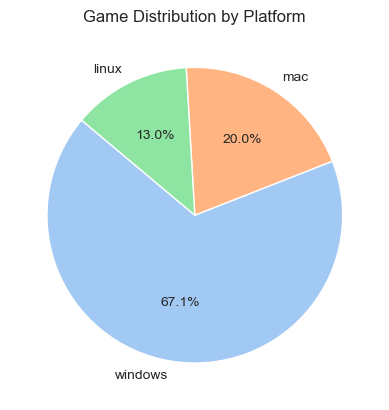

In [262]:
import matplotlib.pyplot as plt
import seaborn as sns

# 拆分平台列
platform_data = steam['platforms'].dropna().str.get_dummies(sep=';')
platform_counts = platform_data.sum().sort_values(ascending=False)

# 简单柔和配色
colors = sns.color_palette("pastel", len(platform_counts))

# 饼图
platform_counts.plot.pie(autopct='%1.1f%%', startangle=140, colors=colors)
plt.ylabel('')
plt.title('Game Distribution by Platform')
plt.show()

平台发行量时间序列

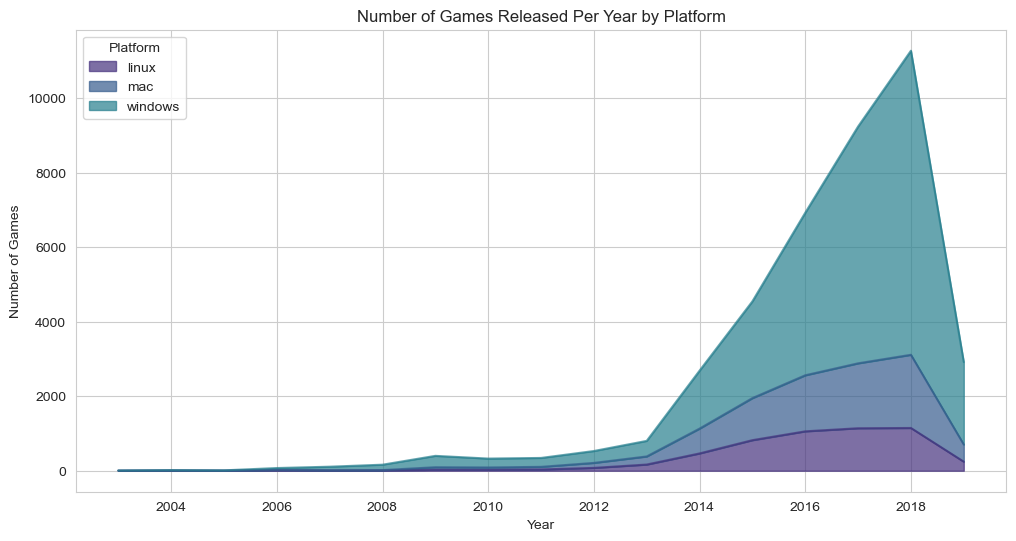

In [263]:
# 拆平台字段
platform_data = steam['platforms'].str.get_dummies(sep=';')
platform_data['year'] = steam['year']

# 各平台按年份统计
platform_yearly = platform_data.groupby('year').sum()

platform_yearly.plot.area(figsize=(12, 6), stacked=True, alpha=0.7)
plt.title('Number of Games Released Per Year by Platform')
plt.ylabel('Number of Games')
plt.xlabel('Year')
plt.legend(title='Platform')
plt.show()

三个平台游戏发行量趋势几乎相同；2013-2018 年游戏发行量激增，2018 年达峰值，后大幅下降。

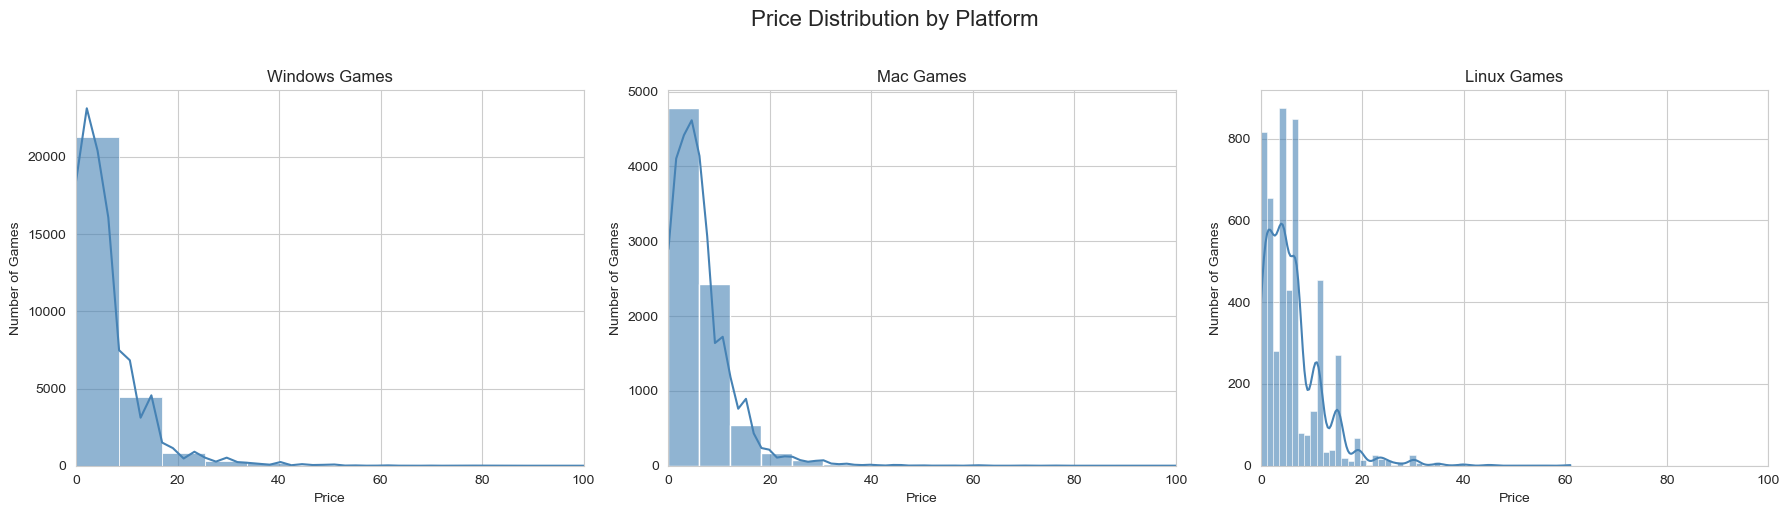

In [264]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

platforms = ['windows', 'mac', 'linux']
min_price = 0
max_price = steam['price'].clip(upper=100).max()  # 最大价格限制为100

# 创建一行三列子图，共享横轴，但纵轴独立
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

for ax, platform in zip(axes, platforms):
    data = steam[platform_data[platform] == 1]['price']
    sns.histplot(
        data,
        bins=50,
        kde=True,       # 核密度估计
        stat='count',
        alpha=0.6,
        color='steelblue',
        ax=ax
    )
    ax.set_title(f'{platform.capitalize()} Games')
    ax.set_xlabel('Price')
    ax.set_ylabel('Number of Games')
    ax.set_xlim(min_price, max_price)  # 横轴对齐
    ax.grid(True)

plt.suptitle('Price Distribution by Platform', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

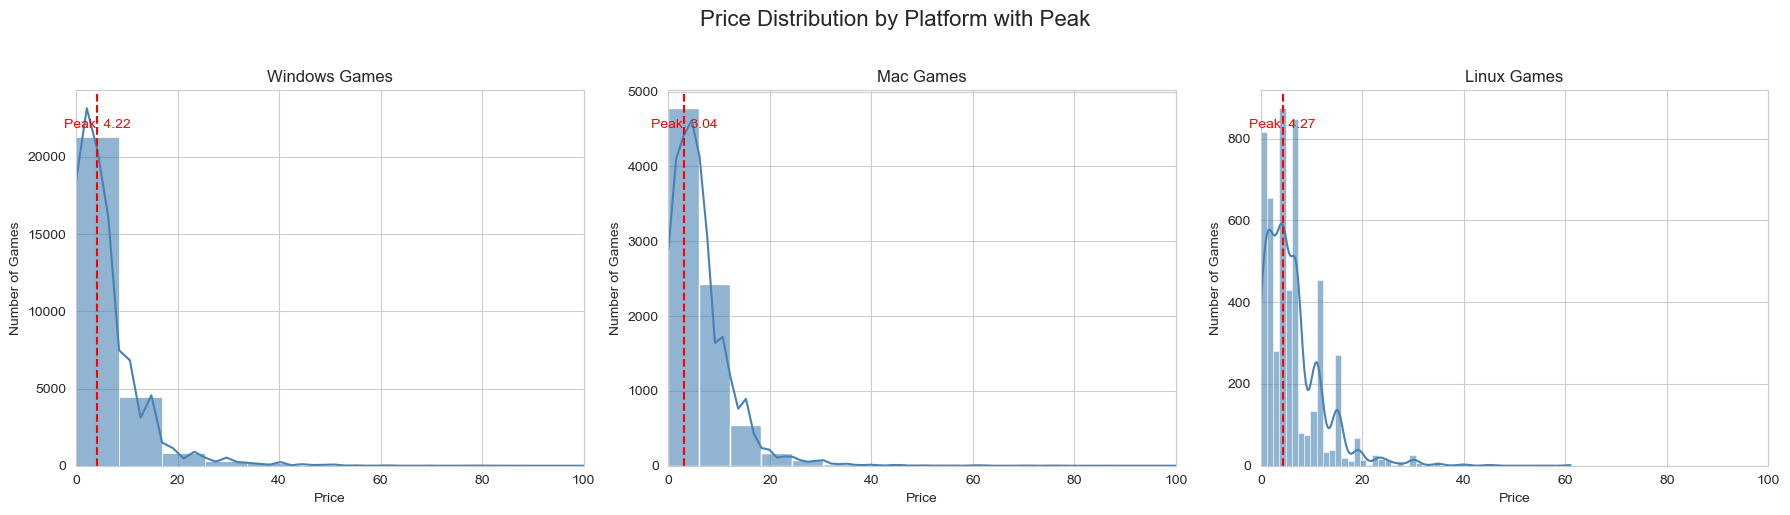

In [265]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")

platforms = ['windows', 'mac', 'linux']
min_price = 0
max_price = steam['price'].clip(upper=100).max()

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

for ax, platform in zip(axes, platforms):
    data = steam[platform_data[platform] == 1]['price']
    
    # 绘制直方图 + KDE
    sns.histplot(data, bins=50, kde=True, stat='count', alpha=0.6, color='steelblue', ax=ax)
    
    # 计算峰值横坐标（直方图中出现次数最多的价格区间中点）
    counts, bin_edges = np.histogram(data, bins=50)
    peak_idx = counts.argmax()
    peak_price = (bin_edges[peak_idx] + bin_edges[peak_idx + 1]) / 2
    
    # 标注峰值
    ax.axvline(peak_price, color='red', linestyle='--', lw=1.5)
    ax.text(peak_price, ax.get_ylim()[1]*0.9, f'Peak: {peak_price:.2f}', color='red', ha='center')
    
    ax.set_title(f'{platform.capitalize()} Games')
    ax.set_xlabel('Price')
    ax.set_ylabel('Number of Games')
    ax.set_xlim(min_price, max_price)
    ax.grid(True)

plt.suptitle('Price Distribution by Platform with Peak', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

- Windows 和 macOS 游戏价格分布相似，集中在 0-20，数量随价格先升高后降低，峰值分别在4.22美元和3.04美元。
    - 大部分游戏定价较低，中低价游戏最受欢迎/最多，形成明显峰值
- Linux 游戏价格集中在 0-20，波动显著，峰值在4.27美元。
    - Linux 游戏数量相对较少，价格波动更大，但同样集中在低价区

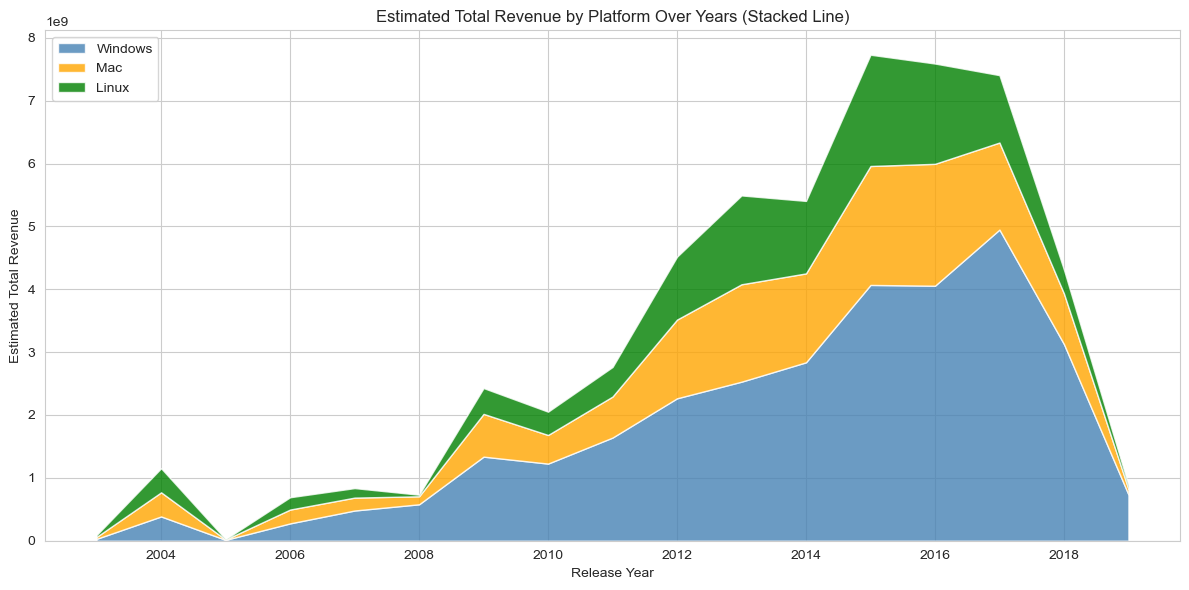

In [266]:

sns.set_style("whitegrid")

# ---------------------- 1. 估算 owners ----------------------
# 假设 steam['owners'] 格式为 "0-20000", "20000-50000", "50000-100000", ...
def owners_midpoint(x):
    try:
        low, high = x.split('-')
        return (int(low.replace(',','')) + int(high.replace(',',''))) / 2
    except:
        return np.nan

steam['owners_est'] = steam['owners'].apply(owners_midpoint)

# ---------------------- 2. 计算营收 ----------------------
steam['revenue'] = steam['price'] * steam['owners_est']

# ---------------------- 3. 合并平台信息 ----------------------
df = platform_data.copy()
df['revenue'] = steam['revenue']

# ---------------------- 4. 按年份汇总每个平台营收 ----------------------
revenue_year_platform = df.groupby('year')[['windows','mac','linux']].apply(
    lambda x: (x.T * df.loc[x.index, 'revenue']).T.sum()
).fillna(0)

# ---------------------- 5. 绘制堆积折线图 ----------------------
plt.figure(figsize=(12,6))
plt.stackplot(
    revenue_year_platform.index,
    revenue_year_platform['windows'],
    revenue_year_platform['mac'],
    revenue_year_platform['linux'],
    labels=['Windows','Mac','Linux'],
    colors=['steelblue','orange','green'],
    alpha=0.8
)
plt.xlabel('Release Year')
plt.ylabel('Estimated Total Revenue')
plt.title('Estimated Total Revenue by Platform Over Years (Stacked Line)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

- 三者增减趋势几乎同步！
- Windows 平台：始终是收入主力，占比长期超过 50%。在 2014-2016 年达到收入峰值（约 2.0×10⁹以上），即使在下滑期（2016-2018）仍保持相对较高的基数，体现其在游戏市场的核心地位。
- Mac 平台：收入占比仅次于 Windows，在 2012-2016 年进入增长高峰，收入区间约 0.8-1.2×10⁹，与 Windows 形成 “双主力” 格局；但下滑阶段（2016-2018）降幅明显，收入快速收缩。
- Linux 平台：收入占比最低，整体呈 “跟随式增长”。在 2012-2016 年的行业高峰期中，收入从约 0.2×10⁹增长至约 1.0×10⁹，成为总收入增长的补充力量；但下滑阶段同样受冲击显著，收入几乎归零。

- 2004 年：三大平台均有初始收入，Windows 占比领先，反映其早期在游戏生态的先发优势。
- 2009-2010 年波动：可能与当时游戏行业的产品周期、经济环境或平台技术迭代（如 Windows 系统更新、Mac 硬件升级）有关，导致收入短暂回调。
- 2012-2016 年高峰：三大平台同步进入收入黄金期，推测是 PC 游戏品类扩张（如独立游戏爆发、3A 大作频繁上线）、用户付费意愿提升、平台生态完善（如 Steam 对多系统的支持）等因素共同驱动的结果。
- 2016 年后下滑：总收入的快速回落可能源于市场饱和、移动端游戏分流、PC 游戏创新不足等行业变化，且 Linux 平台的抗风险能力最弱，率先进入收入低谷。

游戏的平台支持

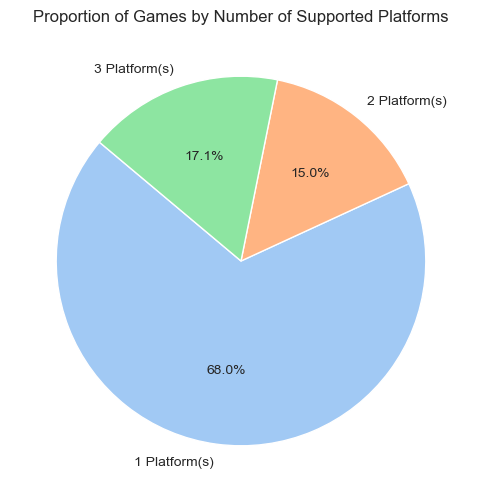

/var/folders/dh/ldptd_p50b56gxq9cz8mf1nr0000gn/T/ipykernel_66750/2401127766.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=revenue_sum.index, y=revenue_sum.values, palette='Blues_r')
/var/folders/dh/ldptd_p50b56gxq9cz8mf1nr0000gn/T/ipykernel_66750/2401127766.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=revenue_mean.index, y=revenue_mean.values, palette='Oranges_r')


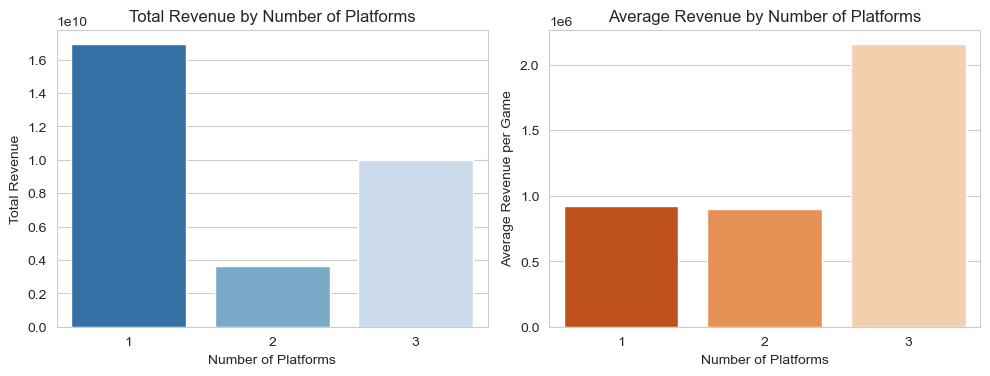

In [267]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------
# 1️⃣ 统计每款游戏支持的平台数量
# --------------------------
df['num_platforms'] = df[['linux', 'mac', 'windows']].sum(axis=1)

# 计算数量和比例
platform_counts = df['num_platforms'].value_counts().sort_index()
platform_ratios = platform_counts / platform_counts.sum()

# 绘制饼图
plt.figure(figsize=(6,6))
plt.pie(platform_ratios, labels=[f'{i} Platform(s)' for i in platform_ratios.index],
        autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title('Proportion of Games by Number of Supported Platforms')
plt.show()

# --------------------------
# 2️⃣ 多平台支持与营收关系
# --------------------------
# 总营收
revenue_sum = df.groupby('num_platforms')['revenue'].sum()
# 平均营收
revenue_mean = df.groupby('num_platforms')['revenue'].mean()

plt.figure(figsize=(10,4))

# 总营收柱状图
plt.subplot(1,2,1)
sns.barplot(x=revenue_sum.index, y=revenue_sum.values, palette='Blues_r')
plt.xlabel('Number of Platforms')
plt.ylabel('Total Revenue')
plt.title('Total Revenue by Number of Platforms')

# 平均营收柱状图
plt.subplot(1,2,2)
sns.barplot(x=revenue_mean.index, y=revenue_mean.values, palette='Oranges_r')
plt.xlabel('Number of Platforms')
plt.ylabel('Average Revenue per Game')
plt.title('Average Revenue by Number of Platforms')

plt.tight_layout()
plt.show()

/var/folders/dh/ldptd_p50b56gxq9cz8mf1nr0000gn/T/ipykernel_66750/1749153592.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='num_platforms', y='price', data=df, palette='Set2')


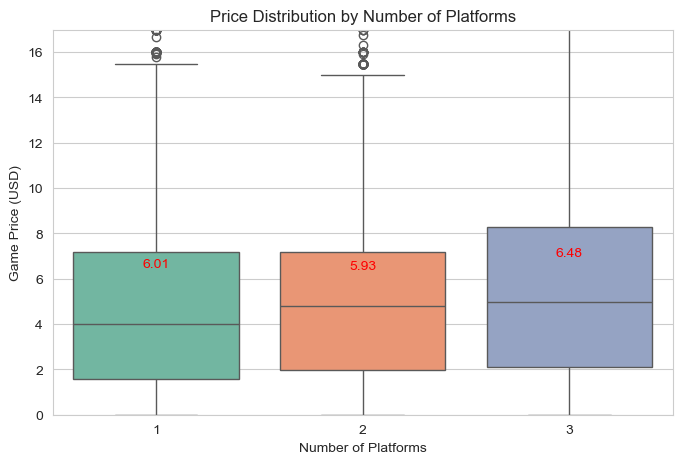

In [268]:
import matplotlib.pyplot as plt
import seaborn as sns

# steam['price'] 对应 df 的索引
df['price'] = steam['price']

plt.figure(figsize=(8,5))
sns.boxplot(x='num_platforms', y='price', data=df, palette='Set2')


# 标注均值
means = df.groupby('num_platforms')['price'].mean()
for i, m in enumerate(means):
    plt.text(i, m + 0.5, f'{m:.2f}', ha='center', color='red')

plt.xlabel('Number of Platforms')
plt.ylabel('Game Price (USD)')
plt.title('Price Distribution by Number of Platforms')
plt.ylim(0, df['price'].quantile(0.95))  # 限制y轴，去掉极端值影响
plt.show()

- 发行量与总营收：
	- 单平台游戏占比68%，数量优势带来总营收最高，这是自然结果。
	- 两平台游戏数量少，总营收稍低，但平均收益和单平台几乎相同，说明数量差异是主要原因。
- 三平台游戏：
	- 平均收益明显高出一倍，说明跨三平台能显著提高收益，而不仅仅是增加发行量。
	- 三平台策略对收入提升有实质性效果，支持两平台的效益提升不明显。
- 策略启示：
	- 如果目标是提高营收，直接扩展到三平台比仅增加到两平台更有效。
	- 对于单平台游戏，简单增加一个平台未必带来收益显著提升。

# 预测性数据分析

1.	单因素业务关联分析：量化游戏核心指标（销量 / 玩家时长 / 威尔逊评分）与关键业务特征的关联性 ——  “不同价格对销量的影响”（已有）“TOP20 标签（ Indie/Action/RPG）与玩家粘性的相关性”“成就数量是否**显著**提升玩家留存（中位游玩时长）”，为开发者制定定价策略、标签运营、内容设计提供量化依据。
2. 
	- 目标变量（y）：游戏热度，可用 revenue、owners_est 或 stickiness 等指标。
	- 解释变量（X）：包括价格、平台、标签组合、开发商历史口碑、早期评价、成就数量、粘性、wlb_score等。


## 单因素业务关联分析

###  top20标签的创收和用户粘性差异

In [269]:
import pandas as pd



# 1. 选择前20热门标签
top_tags_list = tag_counts_df.head(20)['tag'].tolist()

# 2. 初始化结果 DataFrame
tag_stats = []

for tag in top_tags_list:
    # 选出包含该标签的游戏
    mask = steam['tags_aggregated'].str.contains(tag, na=False)
    tag_games = steam[mask]
    
    # 计算总营收和粘性均值
    total_revenue = tag_games['revenue'].sum()
    mean_stickiness = tag_games['stickiness'].mean()
    
    tag_stats.append({
        'tag': tag,
        'total_revenue': total_revenue,
        'mean_stickiness': mean_stickiness,
        'num_games': len(tag_games)
    })

tag_stats_df = pd.DataFrame(tag_stats).sort_values(by='total_revenue', ascending=False)
tag_stats_df

,tag,total_revenue,mean_stickiness,num_games
0,Single-player,2.688637e+10,0.092424,25671
2,Steam Achievements,2.127891e+10,0.118405,14130
3,Action,1.933293e+10,0.107112,11978
6,Steam Trading Cards,1.742772e+10,0.217898,7917
7,Steam Cloud,1.693026e+10,0.145878,7218
13,Multi-player,1.483245e+10,0.157699,3967
8,Full controller support,1.227397e+10,0.125082,5695
5,Adventure,1.194129e+10,0.095668,10118
1,Indie,9.673775e+09,0.084214,19580
11,RPG,6.912330e+09,0.123786,4373


/var/folders/dh/ldptd_p50b56gxq9cz8mf1nr0000gn/T/ipykernel_66750/3947553092.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_revenue', y='tag', data=top_tags_revenue, palette='Blues_r')
/var/folders/dh/ldptd_p50b56gxq9cz8mf1nr0000gn/T/ipykernel_66750/3947553092.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='mean_stickiness', y='tag', data=top_tags_stickiness, palette='Oranges_r')


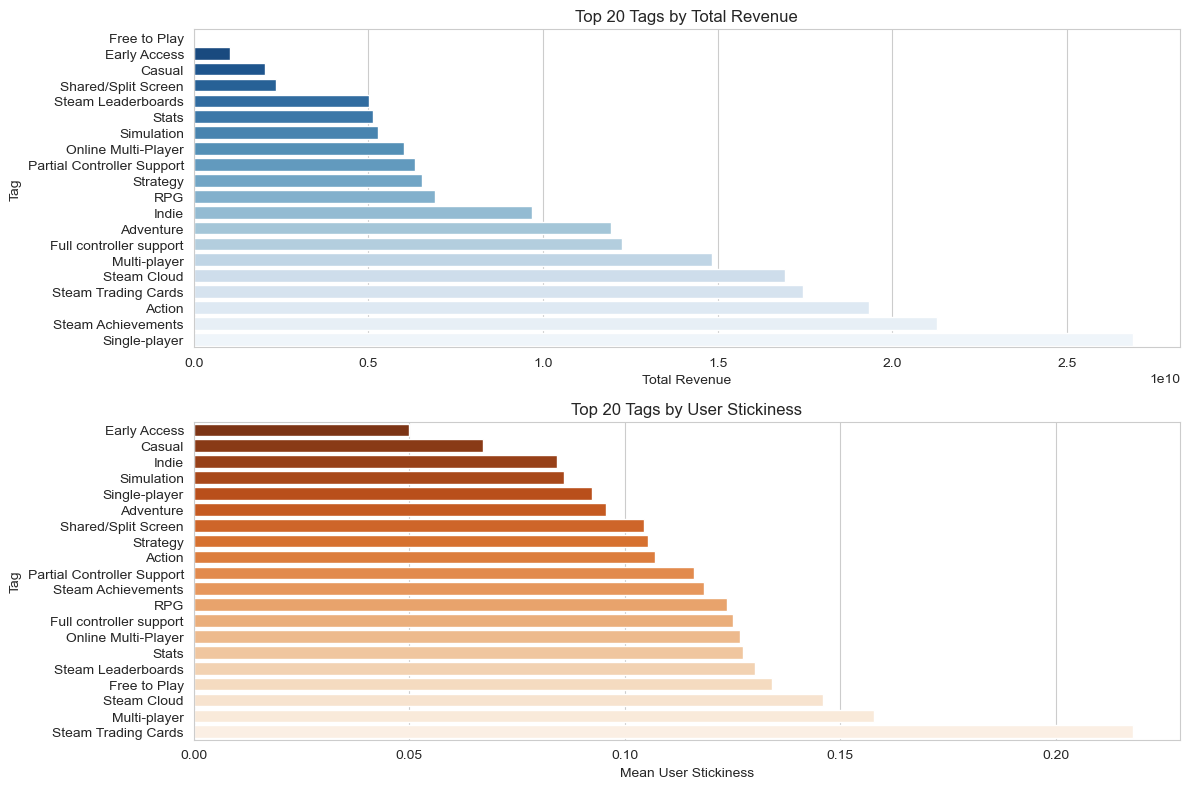

In [270]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# 取前20标签
top_tags = tag_stats_df.head(20)

# 按总营收排序（升序，便于水平条形图）
top_tags_revenue = top_tags.sort_values(by='total_revenue', ascending=True)

# 按用户粘性排序（升序）
top_tags_stickiness = top_tags.sort_values(by='mean_stickiness', ascending=True)

plt.figure(figsize=(12,8))

# 1️⃣ 总营收条形图
plt.subplot(2,1,1)
sns.barplot(x='total_revenue', y='tag', data=top_tags_revenue, palette='Blues_r')
plt.xlabel('Total Revenue')
plt.ylabel('Tag')
plt.title('Top 20 Tags by Total Revenue')

# 2️⃣ 用户粘性条形图
plt.subplot(2,1,2)
sns.barplot(x='mean_stickiness', y='tag', data=top_tags_stickiness, palette='Oranges_r')
plt.xlabel('Mean User Stickiness')
plt.ylabel('Tag')
plt.title('Top 20 Tags by User Stickiness')

plt.tight_layout()
plt.show()

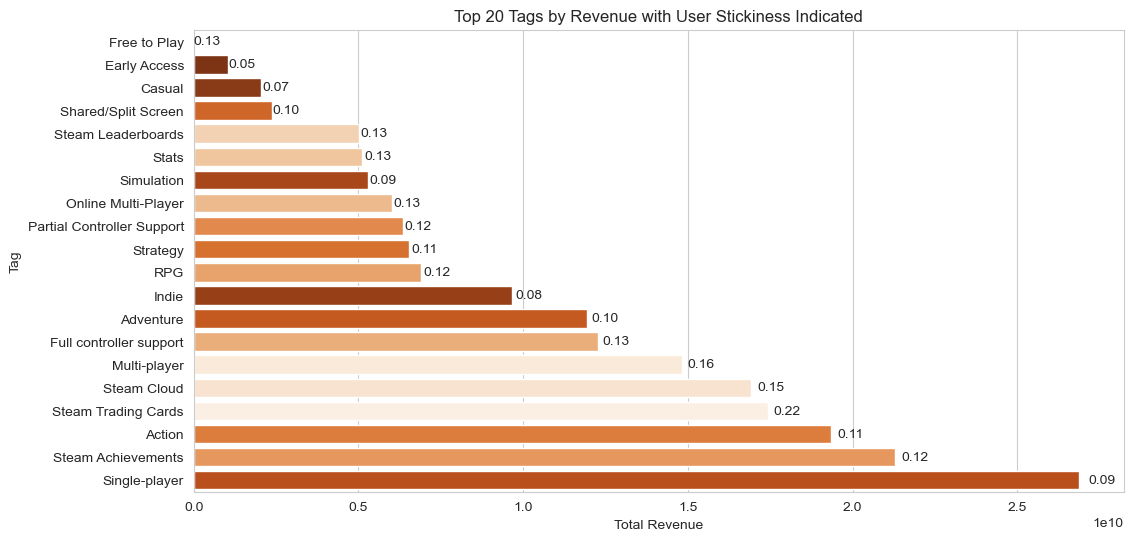

In [271]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# 取前20标签按总营收
top_tags = tag_stats_df.head(20).sort_values(by='total_revenue', ascending=True)

plt.figure(figsize=(12,6))

# 条形长度表示总营收，颜色映射粘性
sns.barplot(
    x='total_revenue', y='tag', data=top_tags,
    palette=sns.color_palette("Oranges_r", n_colors=20),  # 先生成颜色序列
    hue='mean_stickiness', dodge=False  # dodge=False 保证不拆分条形
)

# 用散点或文字标注粘性数值
for i, (revenue, stickiness) in enumerate(zip(top_tags['total_revenue'], top_tags['mean_stickiness'])):
    plt.text(revenue + revenue*0.01, i, f"{stickiness:.2f}", va='center')

plt.xlabel('Total Revenue')
plt.ylabel('Tag')
plt.title('Top 20 Tags by Revenue with User Stickiness Indicated')
plt.legend([],[], frameon=False)  # 去掉多余图例
plt.show()

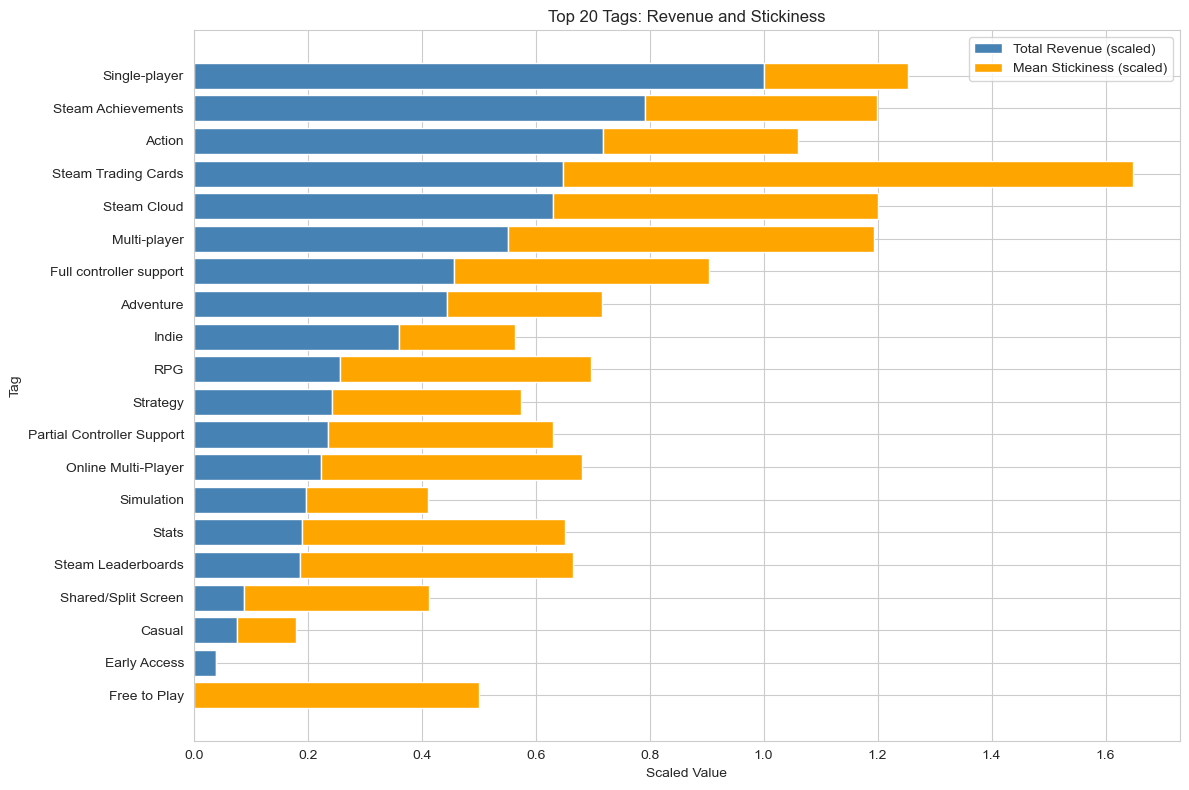

In [272]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

sns.set_style("whitegrid")

# 取前20营收标签
top_tags = tag_stats_df.head(20)

# 按营收排序（升序，便于水平条形图）
top_tags = top_tags.sort_values(by='total_revenue', ascending=True)

# 标准化两个指标
scaler = MinMaxScaler()
top_tags_scaled = top_tags.copy()
top_tags_scaled[['total_revenue_scaled','mean_stickiness_scaled']] = scaler.fit_transform(
    top_tags[['total_revenue','mean_stickiness']]
)

# 绘制水平堆积条形图
plt.figure(figsize=(12,8))

# 左半部分：营收
plt.barh(top_tags_scaled['tag'], top_tags_scaled['total_revenue_scaled'], color='steelblue', label='Total Revenue (scaled)')

# 右半部分：粘性
plt.barh(top_tags_scaled['tag'], top_tags_scaled['mean_stickiness_scaled'], left=top_tags_scaled['total_revenue_scaled'], 
         color='orange', label='Mean Stickiness (scaled)')

plt.xlabel('Scaled Value')
plt.ylabel('Tag')
plt.title('Top 20 Tags: Revenue and Stickiness')
plt.legend()
plt.tight_layout()
plt.show()

- 高营收标签未必对应高粘性（Single-player营收最高但粘性最低），低营收标签也可能有高粘性（如Steam Trading Cards）。游戏的 “赚钱逻辑” 和 “留客逻辑” 是两套体系—— 单人游戏靠优质内容一次性变现，卡牌、多人玩法靠长期互动留存用户
- 
    - 单人游戏（Single-player）：聚焦 “内容质量 + 一次性付费”，通过剧情、画面等核心体验驱动高营收，无需依赖用户长期留存；
    - Steam 集换式卡牌（Steam Trading Cards）：靠 “收藏 + 社交” 属性维持高粘性，可作为游戏的 “附加变现与留存工具”，适合在多人游戏、社区型产品中植入；
    - 多人游戏（Multi-player）、动作 / 角色扮演（Action/RPG）：需平衡 “营收（如内购、dlc）” 与 “粘性（玩法循环、社交绑定）”，通过持续更新玩法、搭建社区来维持用户活跃与付费。
- Free to Play（免费游玩）、Indie（独立游戏）等低营收标签中，部分粘性较高（如Free to Play粘性 0.13），说明免费模式、独立游戏可通过 “细分受众 + 差异化体验” 实现用户留存，适合作为 “niche 市场切入点”，后续可通过周边、社群运营挖掘商业价值。

### 成就数量和玩家粘性差异

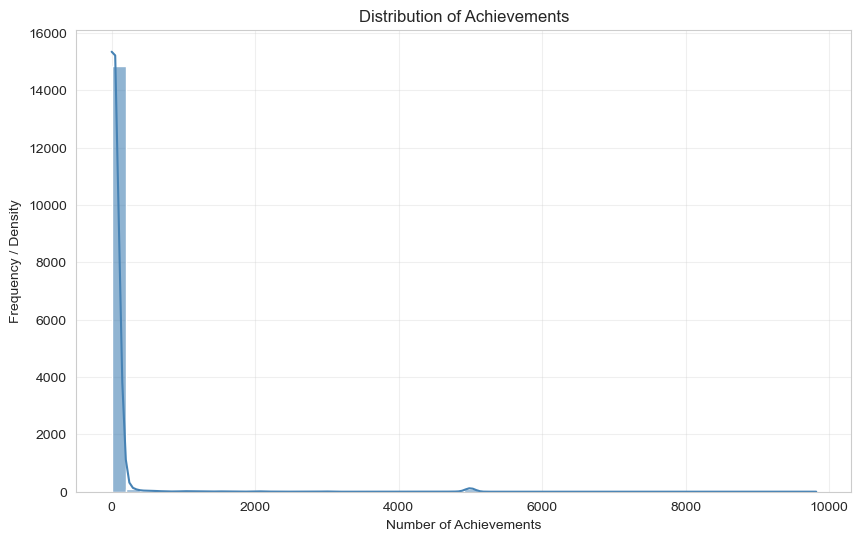

In [273]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize=(10,6))

# 过滤掉缺失或0值
achievements_data = steam['achievements'].dropna()
achievements_data = achievements_data[achievements_data > 0]

# 绘制直方图 + KDE
sns.histplot(achievements_data, bins=50, kde=True, color='steelblue', alpha=0.6)

plt.title('Distribution of Achievements')
plt.xlabel('Number of Achievements')
plt.ylabel('Frequency / Density')
plt.grid(alpha=0.3)
plt.show()

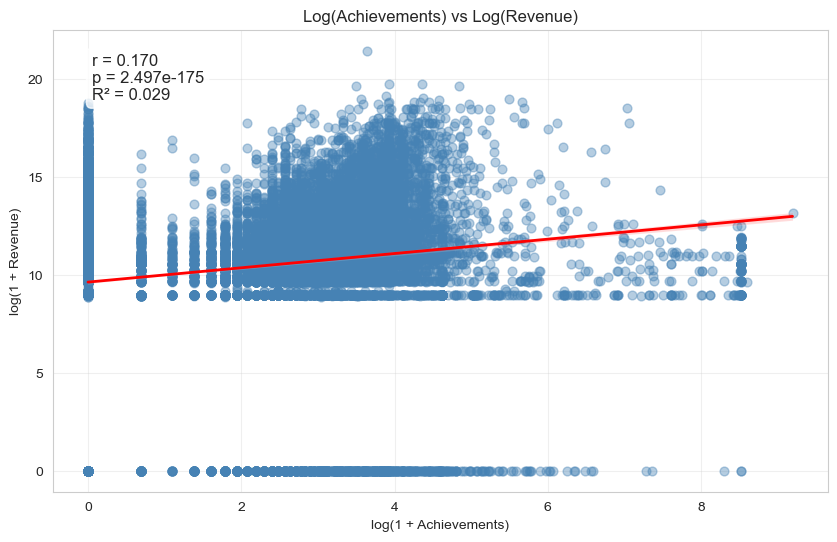

In [274]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

# ----------------------------
# 1. 数据预处理（不改原表）
# ----------------------------
x = np.log1p(steam['achievements'])  # log(1+x) 防止0报错
y = np.log1p(steam['revenue'])

# 去除 NaN / Inf
mask = np.isfinite(x) & np.isfinite(y)
x, y = x[mask], y[mask]

# ----------------------------
# 2. 计算统计指标
# ----------------------------
r, p = stats.pearsonr(x, y)  # 皮尔逊相关系数
X = sm.add_constant(x)
model = sm.OLS(y, X).fit()
r2 = model.rsquared

# ----------------------------
# 3. 绘图
# ----------------------------
sns.set_style("whitegrid")
plt.figure(figsize=(10,6))

sns.regplot(
    x=x, y=y,
    scatter_kws={'alpha':0.4, 's':40, 'color':'steelblue'},
    line_kws={'color':'red', 'lw':2}
)

# 注释
plt.text(
    0.05, 0.95,
    f"r = {r:.3f}\np = {p:.3e}\nR² = {r2:.3f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8)
)

plt.title('Log(Achievements) vs Log(Revenue)')
plt.xlabel('log(1 + Achievements)')
plt.ylabel('log(1 + Revenue)')
plt.grid(alpha=0.3)
plt.show()

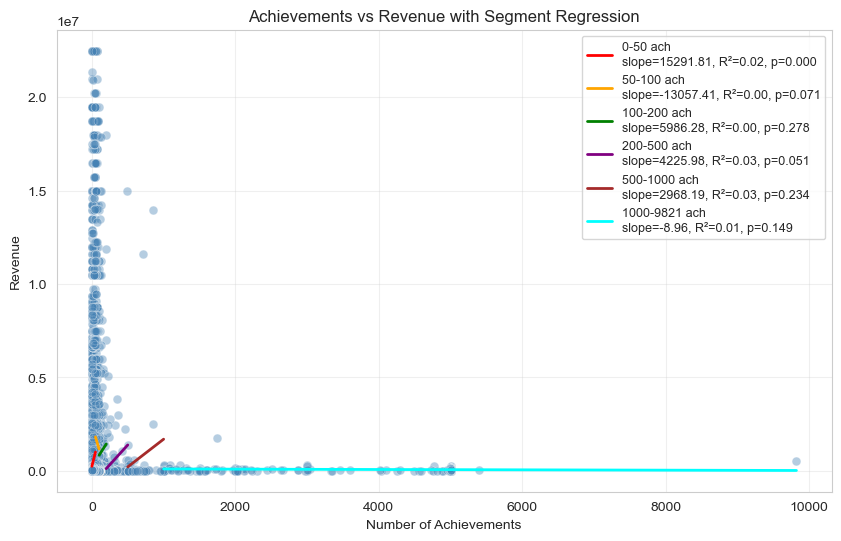

       range         slope     intercept   r_value  r_squared       p_value  \
0       0-50  15291.812566  2.366424e+05  0.124762   0.015566  7.330127e-86   
1     50-100 -13057.410311  2.464048e+06 -0.047017   0.002211  7.075986e-02   
2    100-200   5986.281729  2.309562e+05  0.056031   0.003139  2.784912e-01   
3    200-500   4225.984874 -7.338143e+05  0.182074   0.033151  5.147330e-02   
4   500-1000   2968.192400 -1.279099e+06  0.175040   0.030639  2.340616e-01   
5  1000-9821     -8.960579  1.014764e+05 -0.103265   0.010664  1.487285e-01   

       n  
0  24585  
1   1478  
2    376  
3    115  
4     48  
5    197  


In [275]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import numpy as np
import pandas as pd

sns.set_style("whitegrid")
plt.figure(figsize=(10,6))

# ---------------------------
# 1️⃣ 纵轴过滤异常值（保持横轴原始）
# ---------------------------
y_upper = steam['revenue'].quantile(0.99)  # 排除最高1%极端值
df_filtered = steam[steam['revenue'] <= y_upper]

# ---------------------------
# 2️⃣ 散点图
# ---------------------------
sns.scatterplot(
    data=df_filtered,
    x='achievements',
    y='revenue',
    alpha=0.4, s=40, color='steelblue'
)

# ---------------------------
# 3️⃣ 分段回归
# ---------------------------
bins = [0, 50, 100, 200, 500, 1000, df_filtered['achievements'].max()]
colors = ['red', 'orange', 'green', 'purple', 'brown', 'cyan']

results = []  # 保存每段的回归结果

for i in range(len(bins)-1):
    segment = df_filtered[(df_filtered['achievements'] >= bins[i]) & (df_filtered['achievements'] < bins[i+1])]
    if len(segment) >= 10:
        slope, intercept, r_value, p_value, std_err = linregress(segment['achievements'], segment['revenue'])
        r_squared = r_value**2
        results.append({
            'range': f'{bins[i]}-{bins[i+1]}',
            'slope': slope,
            'intercept': intercept,
            'r_value': r_value,
            'r_squared': r_squared,
            'p_value': p_value,
            'n': len(segment)
        })
        # 绘制回归线
        x_vals = np.array([bins[i], bins[i+1]])
        y_vals = intercept + slope * x_vals
        plt.plot(
            x_vals, y_vals, color=colors[i], lw=2,
            label=f"{bins[i]}-{bins[i+1]} ach\nslope={slope:.2f}, R²={r_squared:.2f}, p={p_value:.3f}"
        )

plt.xlabel('Number of Achievements')
plt.ylabel('Revenue')
plt.title('Achievements vs Revenue with Segment Regression')
plt.legend(fontsize=9)
plt.grid(alpha=0.3)
plt.show()

# 输出分段回归结果
results_df = pd.DataFrame(results)
print(results_df)

- 仅在 “成就数量极少” 的区间存在微弱正相关，但整体解释力极低；
- 绝大多数区间内，成就数量与营收无明确线性关联，即 “成就数不是营收的核心驱动因素”；
- 过度堆砌成就（1000 个以上）甚至可能对营收产生微弱负面影响（虽不显著）
- 简言之，游戏成就系统对营收的作用非常有限，核心仍需依赖游戏本身的内容质量、玩法设计等因素，成就仅能作为辅助性的用户体验优化工具，而非增收利器

## 游戏热度预测模型特征体系

| 类别 | 列名 | 用途 / 作用 | 处理建议 |
|------|------|-------------|-----------|
| **基本信息** | price | 游戏定价，影响玩家购买意愿和初期热度 | 对数变换或标准化 |
|  | platforms | 支持的平台数量（1/2/3），潜在玩家量 | 直接计数或独热编码 |
|  | owners_est | 玩家规模估计（区间中点），反映市场基础 | 对数变换或标准化 |
| **用户行为** | stickiness | 综合用户粘性指标，反映玩家活跃度 | 标准化 |
|  | achievements | 游戏成就数量，间接反映可玩性 | 对数变换或标准化 |
|  | wlb_score | 好评率或 Wilson Score，反映用户满意度 | 标准化或直接使用 |
| **游戏属性** | tags_aggregated | 核心标签，反映玩家兴趣和玩法偏好 | 选前 N 个热门标签，独热编码或 embedding |
| **衍生特征** | early_growth | 早期玩家增长速度 = owners_est / days_since_release | 标准化，可选 |

#### 核心思路
- **行为特征**（stickiness、achievements、wlb_score）直接捕捉玩家真实行为和热度。  
- **属性特征**（price、platforms、top_tags、developer）反映市场潜力和玩家偏好。  
- 保留最核心特征，降低维度，保证模型可解释性和易操作性。

### 基本信息

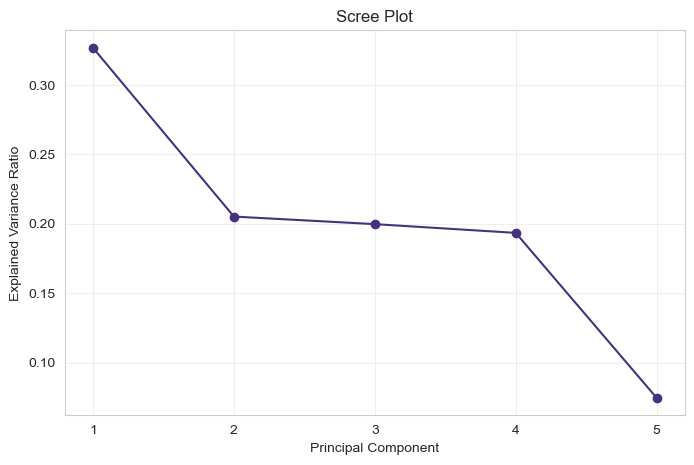

In [276]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ 拆分平台列并独热编码
platform_dummies = steam['platforms'].str.get_dummies(sep=';')

# 2️⃣ 选取基本特征
basic_features = pd.concat([steam[['price', 'owners_est']], platform_dummies], axis=1)

# 3️⃣ 标准化
scaler = StandardScaler()
basic_features_scaled = scaler.fit_transform(basic_features)

# 4️⃣ PCA 不指定 n_components
pca = PCA()
pca.fit(basic_features_scaled)

# 5️⃣ 碎石图
explained_var = pca.explained_variance_ratio_
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_var)+1), explained_var, marker='o', linestyle='-')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_var)+1))
plt.grid(alpha=0.3)
plt.show()

取前三个主成分，即可达到70%左右解释率

In [277]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd

# 1️⃣ 拆分平台列并独热编码
platform_dummies = steam['platforms'].str.get_dummies(sep=';')

# 2️⃣ 选取基本特征
basic_features = pd.concat([steam[['price', 'owners_est']], platform_dummies], axis=1)

# 3️⃣ 标准化
scaler = StandardScaler()
basic_features_scaled = scaler.fit_transform(basic_features)

# 4️⃣ PCA，取前两个主成分
pca = PCA(n_components=3)
principal_components = pca.fit_transform(basic_features_scaled)

# 5️⃣ 将结果放回 DataFrame
pc_df = pd.DataFrame(principal_components, columns=['PC1', 'PC2', 'PC3'])
pc_df.head()

,PC1,PC2,PC3
0,3.054912,3.263138,-0.511636
1,3.632908,7.311236,-1.228997
2,3.632908,7.311236,-1.228997
3,3.632908,7.311236,-1.228997
4,2.734318,0.893660,-0.096570


### 用户行为
Wilson score 公式如下（取置信度 95%，z=1.96）：

$$\text{Wilson Lower Bound} = \frac{ \hat{p} + \frac{z^2}{2n} - z \sqrt{ \frac{\hat{p}(1-\hat{p}) + \frac{z^2}{4n}}{n} } }{ 1 + \frac{z^2}{n} }
$$
$$
其中：
	\hat{p} = \frac{\text{positive}}{n},
	n = \text{positive} + \text{negative},
	z = 1.96 对应置信度 95%
$$

In [278]:
import numpy as np
import pandas as pd

# 防止除0
def wilson_lower_bound(pos, neg, confidence=0.95):
    n = pos + neg
    if n == 0:
        return np.nan
    z = 1.96  # 95%置信区间
    phat = 1.0 * pos / n
    return (phat + z*z/(2*n) - z * np.sqrt((phat*(1-phat) + z*z/(4*n)) / n)) / (1 + z*z/n)

# 计算并添加新列
steam['wlb_score'] = steam.apply(lambda row: wilson_lower_bound(row['positive_ratings'], row['negative_ratings']), axis=1)

# 检查结果
steam['wlb_score'].describe()

count    27064.000000
mean         0.531145
std          0.253558
min          0.000000
25%          0.342372
50%          0.560072
75%          0.740831
max          0.986165
Name: wlb_score, dtype: float64

In [279]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# 1️⃣ 提取用户行为特征
behavior_features = steam[['stickiness', 'achievements', 'wlb_score']].copy()

# 2️⃣ achievements 对数变换（避免 log(0) 出错）
behavior_features['achievements_log'] = np.log1p(behavior_features['achievements'])

# 3️⃣ stickiness 加一个微小常数避免过多0对建模影响
# 方法：加1e-3
behavior_features['stickiness_adj'] = behavior_features['stickiness'] + 1e-3

# 4️⃣ 标准化
scaler = StandardScaler()
behavior_scaled = scaler.fit_transform(behavior_features[['stickiness_adj', 'achievements_log', 'wlb_score']])

# 5️⃣ 放回 DataFrame
behavior_scaled_df = pd.DataFrame(behavior_scaled, columns=['stickiness_scaled', 'achievements_scaled', 'wlb_scaled'])
behavior_scaled_df.head()

,stickiness_scaled,achievements_scaled,wlb_scaled
0,1.426836,-1.013790,1.397730
1,1.660842,-1.013790,1.409685
2,2.260269,1.019572,1.708057
3,2.765058,1.867691,1.671370
4,1.836264,-1.013790,0.940644


在原始数据中，stickiness（用户粘性）存在大量零值，若直接用于建模可能导致以下问题：
	1.	对数变换不可行：
由于 log(0) 不存在，零值会引发数值错误或被强制舍弃，造成数据样本损失。
	2.	模型不稳定性：
含有大量零值的特征在标准化或回归时会导致方差极低，从而降低模型对该变量的灵敏度。
	3.	避免“假零”误导模型：
部分 stickiness = 0 的记录可能并非“完全无粘性”，而是由于数据采样、统计口径等原因产生的“技术性零值”。

因此，为了保证对数变换和建模的数值稳定性，同时不影响整体分布结构，在 stickiness 上加上极小常数（1e-3）：

### 游戏属性

补充硬件配置的要求

In [280]:

import re
import ast

# 读取数据
req_df = pd.read_csv('steam_requirements_data.csv')

# 尝试解析嵌套字符串
def parse_requirements(text):
    try:
        d = ast.literal_eval(text)
        if isinstance(d, dict) and 'minimum' in d:
            return d['minimum']
        else:
            return str(text)
    except:
        return str(text)

for col in ['pc_requirements', 'mac_requirements', 'linux_requirements']:
    req_df[col] = req_df[col].apply(parse_requirements)

# 提取关键字（CPU / GPU / RAM）
def extract_spec_level(text):
    text = text.lower()
    # 简单基于关键词的粗分级
    if re.search(r'gtx|rtx|radeon|core i[3579]|ryzen', text):
        return 3  # 高配置
    elif re.search(r'dual[- ]core|2\.|intel|amd', text):
        return 2  # 中配置
    elif re.search(r'500|800|96mb|128mb|xp', text):
        return 1  # 低配置
    else:
        return 0  # 无法识别

req_df['pc_level'] = req_df['pc_requirements'].apply(extract_spec_level)
req_df['mac_level'] = req_df['mac_requirements'].apply(extract_spec_level)
req_df['linux_level'] = req_df['linux_requirements'].apply(extract_spec_level)

# 平均得到硬件需求强度
req_df['hardware_demand'] = req_df[['pc_level', 'mac_level', 'linux_level']].mean(axis=1)

# 合并入主表 steam
steam = steam.merge(req_df[['steam_appid', 'hardware_demand']], 
                    left_on='appid', right_on='steam_appid', how='left')

steam.head(1)

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,...,year,owners_left,owner_group,tags_aggregated,stickiness,owners_est,revenue,wlb_score,steam_appid,hardware_demand
0,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,...,2003,5000000,Head,Action;FPS;Multi-player;Multiplayer;Valve Anti...,0.360151,7500000.0,29925000.0,0.885544,30.0,1.666667


In [281]:
steam['hardware_demand'].fillna(0, inplace=True)

In [282]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# -------- Step 1. 标签预处理 --------
def clean_tags(x):
    if pd.isna(x):
        return ''
    return ' '.join(str(x).replace(';', ' ').replace(',', ' ').split())

steam['tags_clean'] = steam['tags_aggregated'].apply(clean_tags)

# -------- Step 2. TF-IDF 向量化 --------
vectorizer = TfidfVectorizer(max_features=1000)  # 可调，比如1000或2000
tfidf_matrix = vectorizer.fit_transform(steam['tags_clean'])

# -------- Step 3. PCA降维（建议10维左右）--------
pca = PCA(n_components=10, random_state=42)
tag_emb = pca.fit_transform(tfidf_matrix.toarray())

# -------- Step 4. 标准化（保持与其他数值特征量级一致）--------
scaler = StandardScaler()
tag_emb_scaled = scaler.fit_transform(tag_emb)

# -------- Step 5. 合并回主表 --------
tag_emb_df = pd.DataFrame(tag_emb_scaled, columns=[f'tag_emb_{i+1}' for i in range(tag_emb_scaled.shape[1])])
steam = pd.concat([steam.reset_index(drop=True), tag_emb_df], axis=1)

# 可选：查看PCA方差解释率
explained_var = pca.explained_variance_ratio_.sum()
print(f"PCA embedding explains {explained_var:.2%} of tag variance.")

PCA embedding explains 41.92% of tag variance.


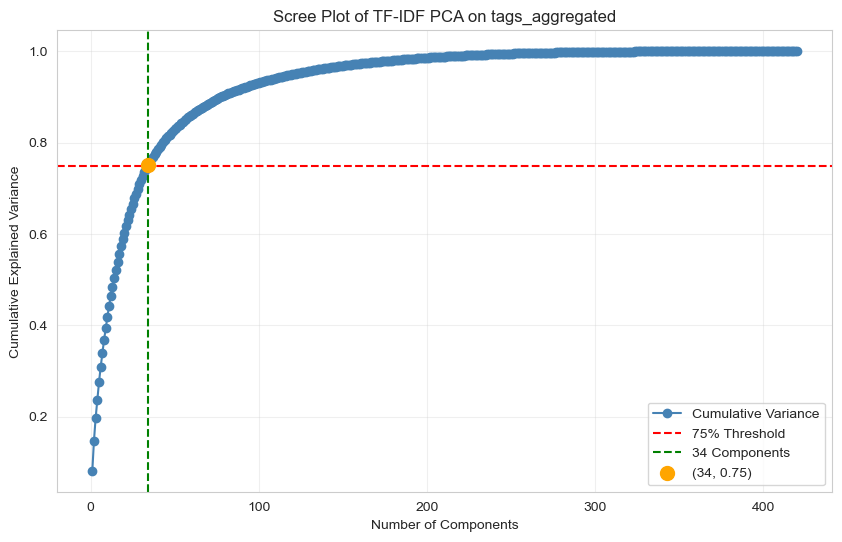

In [283]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

# -------- 标签预处理 --------
def clean_tags(x):
    if pd.isna(x):
        return ''
    return ' '.join(str(x).replace(';', ' ').replace(',', ' ').split())

steam['tags_clean'] = steam['tags_aggregated'].apply(clean_tags)

# -------- TF-IDF 向量化 --------
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = vectorizer.fit_transform(steam['tags_clean'])

# -------- PCA --------
pca = PCA(n_components=min(tfidf_matrix.shape[0], tfidf_matrix.shape[1]))
pca.fit(tfidf_matrix.toarray())
explained_var_ratio = pca.explained_variance_ratio_
cumulative_var = explained_var_ratio.cumsum()

# -------- 找到75%累计方差对应的主成分 --------
n_components_75 = np.argmax(cumulative_var >= 0.75) + 1
var_75 = cumulative_var[n_components_75-1]

# -------- 绘图 --------
plt.figure(figsize=(10,6))
plt.plot(range(1, len(cumulative_var)+1), cumulative_var, marker='o', color='steelblue', label='Cumulative Variance')
plt.axhline(y=0.75, color='red', linestyle='--', label='75% Threshold')
plt.axvline(x=n_components_75, color='green', linestyle='--', label=f'{n_components_75} Components')
plt.scatter(n_components_75, var_75, color='orange', s=100, zorder=5, label=f'({n_components_75}, {var_75:.2f})')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot of TF-IDF PCA on tags_aggregated')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

选择保留前34个主成分，方差解释率达到75%

In [284]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

# 1️⃣ 构建 TF-IDF 矩阵
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(steam['tags_aggregated'].fillna(''))

# 2️⃣ PCA降维，保留前34个主成分
pca = PCA(n_components=34, random_state=42)
tags_pca = pca.fit_transform(tfidf_matrix.toarray())

# 3️⃣ 将PCA特征加入steam表
import numpy as np
pca_cols = [f'tag_pc_{i+1}' for i in range(34)]
tags_pca_df = pd.DataFrame(tags_pca, columns=pca_cols, index=steam.index)

steam = pd.concat([steam, tags_pca_df], axis=1)

# 检查
steam[pca_cols].head()

,tag_pc_1,tag_pc_2,tag_pc_3,tag_pc_4,tag_pc_5,tag_pc_6,tag_pc_7,tag_pc_8,tag_pc_9,tag_pc_10,...,tag_pc_25,tag_pc_26,tag_pc_27,tag_pc_28,tag_pc_29,tag_pc_30,tag_pc_31,tag_pc_32,tag_pc_33,tag_pc_34
0,-0.248104,-0.154278,-0.062825,-0.094014,-0.146977,-0.029876,0.018878,-0.112786,-0.034484,0.133816,...,-0.054576,0.003729,-0.029065,0.088329,-0.040410,-0.036409,-0.113467,0.025317,-0.018888,-0.204971
1,-0.255155,-0.134887,-0.046788,-0.057178,-0.128078,-0.001897,0.007148,-0.089755,-0.011471,0.144634,...,-0.046936,0.002504,-0.014005,0.071048,-0.022229,-0.021499,-0.049584,0.015222,-0.004150,-0.150038
2,0.129927,-0.145941,-0.008700,-0.149192,-0.105852,-0.102763,0.016349,-0.101918,-0.046780,0.043831,...,-0.022313,0.256949,-0.073896,-0.063812,-0.021771,-0.017382,-0.045040,-0.021117,-0.019913,-0.068654
3,-0.113045,-0.201385,-0.151417,-0.085442,-0.107903,-0.006799,-0.046197,-0.053921,-0.021628,0.142672,...,-0.097628,0.016242,-0.102309,0.209329,-0.003562,0.016683,0.121162,0.120908,0.075346,-0.187777
4,-0.206063,-0.044433,0.014552,-0.102843,-0.138857,-0.041299,0.019951,-0.145122,-0.035653,0.190745,...,-0.035755,-0.003750,0.004352,0.035624,-0.047498,-0.038694,-0.119564,0.036907,-0.055017,-0.165720


### 衍生特征

In [285]:
import pandas as pd

# 计算距今天数
from datetime import datetime

# 将 release_date 转为 datetime 类型（如果尚未转换）
steam['release_date'] = pd.to_datetime(steam['release_date'], errors='coerce')

# 计算上线天数，避免负值或缺失
steam['days_since_release'] = (datetime.now() - steam['release_date']).dt.days
steam['days_since_release'] = steam['days_since_release'].clip(lower=1)  # 避免除零

# 构建 early_growth 特征
steam['early_growth'] = steam['owners_est'] / steam['days_since_release']
# 标准化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
steam['early_growth_scaled'] = scaler.fit_transform(steam[['early_growth']])


R^2: 0.296, MAE: 372659.61


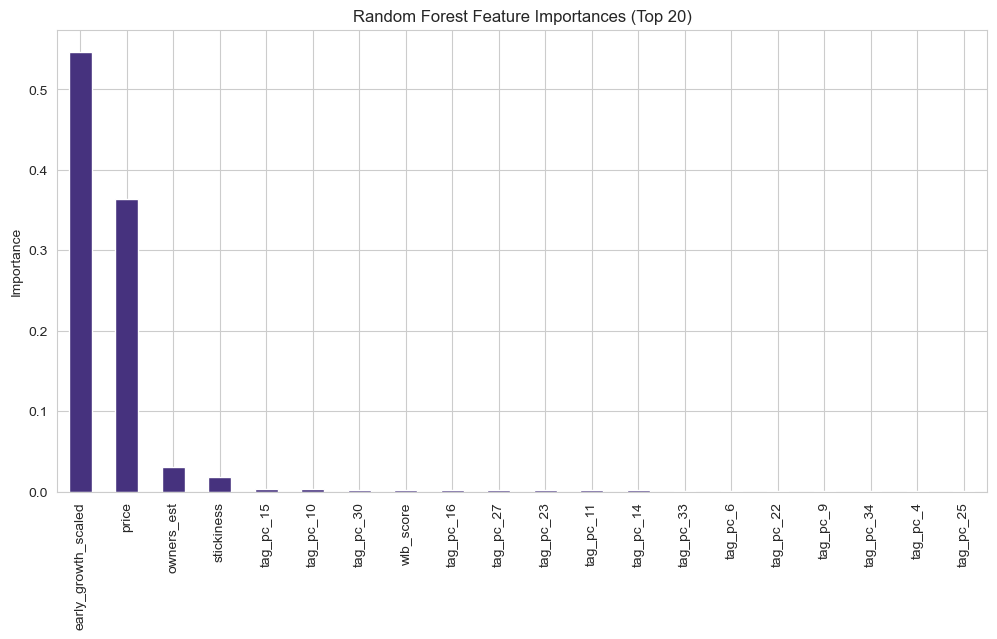

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# -----------------------------
# 1️⃣ 选择特征
# -----------------------------
num_features = ['price', 'owners_est', 'stickiness', 'achievements', 'wlb_score', 'early_growth_scaled']
tag_pc_features = [f'tag_pc_{i}' for i in range(1, 35)]           # 34个PCA标签主成分

feature_cols = num_features+ tag_pc_features
X = steam[feature_cols]
y = steam['revenue']

# -----------------------------
# 2️⃣ 划分训练集/测试集
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -----------------------------
# 3️⃣ 数值特征标准化（embedding 和 PCA 不必标准化）
# -----------------------------
scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

# -----------------------------
# 4️⃣ 随机森林回归
# -----------------------------
rf = RandomForestRegressor(n_estimators=300, max_depth=12, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# -----------------------------
# 5️⃣ 模型预测与评估
# -----------------------------
y_pred = rf.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"R^2: {r2:.3f}, MAE: {mae:.2f}")

# -----------------------------
# 6️⃣ 特征重要性可视化
# -----------------------------
importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
plt.figure(figsize=(12,6))
importances.head(20).plot(kind='bar')   # 只显示前20重要特征
plt.title("Random Forest Feature Importances (Top 20)")
plt.ylabel("Importance")
plt.show()

几乎所有标签的权重都非常小

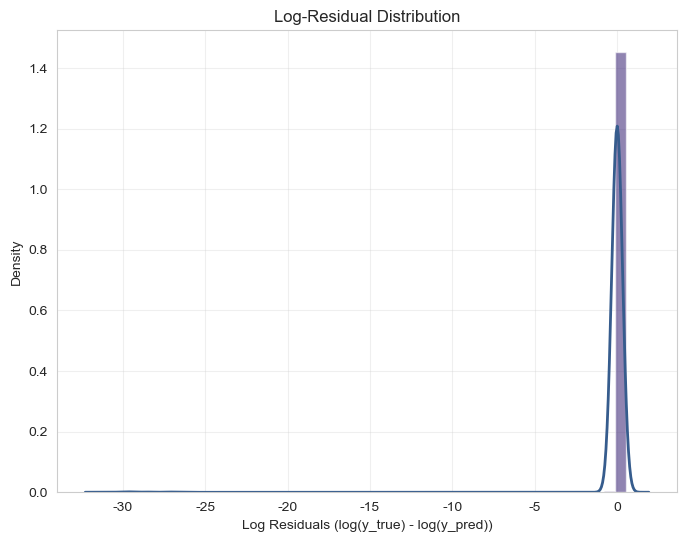

In [287]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# -----------------------------
# 1. 预测
# -----------------------------
y_pred = rf.predict(X_test)

# -----------------------------
# 2. 对真实值和预测值取对数（防止 log(0)）
# -----------------------------
epsilon = 1e-8
y_test_log = np.log(y_test + epsilon)
y_pred_log = np.log(y_pred + epsilon)

# -----------------------------
# 3. 计算对数残差
# -----------------------------
residuals = y_test_log - y_pred_log

# -----------------------------
# 4. 残差分布：直方图 + KDE
# -----------------------------
plt.figure(figsize=(8, 6))

plt.hist(residuals, bins=50, density=True, alpha=0.6)

kde = gaussian_kde(residuals)
x = np.linspace(residuals.min(), residuals.max(), 500)
plt.plot(x, kde(x), linewidth=2)

plt.xlabel('Log Residuals (log(y_true) - log(y_pred))')
plt.ylabel('Density')
plt.title('Log-Residual Distribution')
plt.grid(alpha=0.3)
plt.show()

为了可解释性，选择四个核心特征，线性回归建模

In [288]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 选特征和目标
X = steam[['early_growth', 'price', 'stickiness', 'wlb_score']].copy()
y = steam['revenue'].copy()

# 对 revenue 取对数（加小常数避免0值）
y_log = np.log1p(y)  # log(1 + y)

# stickiness 加微小常数避免0值
X['stickiness_adj'] = X['stickiness'] + 1e-3

# 添加常数项
X = sm.add_constant(X[['early_growth', 'price', 'stickiness_adj', 'wlb_score']])

# 权重：使用 owners_est 或 early_growth
weights = steam['owners_est']  # 可换成 early_growth 或其他

# 构建加权线性回归模型
wls_model = sm.WLS(y_log, X, weights=weights)
wls_results = wls_model.fit()

# 输出结果
print(wls_results.summary())

# 拿回归系数
coef = wls_results.params
print("回归系数：")
print(coef)

# 预测值
y_pred = wls_results.predict(X)

# 评估指标
r2 = wls_results.rsquared
mae = mean_absolute_error(y_log, y_pred)
rmse = mean_squared_error(y_log, y_pred) ** 0.5

print(f"R²: {r2:.3f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")

                            WLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.516
Model:                            WLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     7199.
Date:                Wed, 21 Jan 2026   Prob (F-statistic):               0.00
Time:                        00:15:20   Log-Likelihood:            -1.0833e+05
No. Observations:               27064   AIC:                         2.167e+05
Df Residuals:                   27059   BIC:                         2.167e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.1230      0.143     35.

### 游戏热度预测模型业务解读（加权线性回归）

##### 1️⃣ 模型整体表现
- **R² = 0.515**：模型解释了约 51.5% 的 log(revenue) 变动，四个特征对游戏热度有较强解释力。  
- **MAE = 2.89、RMSE = 4.13**：对数收入尺度下的平均误差和均方根误差，说明拟合整体稳健。  

> ⚡ 结论：模型比随机森林可解释性更强，适合给业务提供具体策略参考。

##### 2️⃣ 回归系数及业务含义

| 特征 | 系数 | 含义 | 业务解读 |
|------|------|------|-----------|
| const | 5.131 | 截距 | 当其他特征为 0 时，log(revenue) 的基准值 |
| early_growth | -0.0002 | 对 log(revenue) 的负向影响 | 系数虽显著，但值很小，早期增长对长期收入影响有限 |
| price | 0.498 | 对 log(revenue) 的正向影响 | 游戏价格越高，玩家购买意愿越强，收入明显增加 |
| stickiness_adj | -0.429 | 对 log(revenue) 的负向影响 | 高粘性可能集中在小众或免费游戏，收入未必高 |
| wlb_score | 2.997 | 对 log(revenue) 的正向影响 | 好评率越高，玩家满意度越高，直接提升收入，是最强行为驱动因素 |

> ⚡ 结论：**价格和好评率是收入的关键驱动因素**，stickiness 与 early_growth 影响较弱。

##### 3️⃣ 业务启示
1. **定价策略**：合理提高价格可直接提升初期收入，但需结合市场和标签偏好优化。  
2. **用户评价管理**：提升好评率（wlb_score）最显著，可通过优化内容、社区互动、早期运营干预实现。  
3. **粘性与增长**：高粘性和早期增长未必立即带来高收入，但可能影响长期留存和口碑传播，可作为次级指标。  
4. **可解释性优势**：相比随机森林，加权线性模型可直接量化每个特征的影响方向与大小，便于产品和开发团队参考决策。

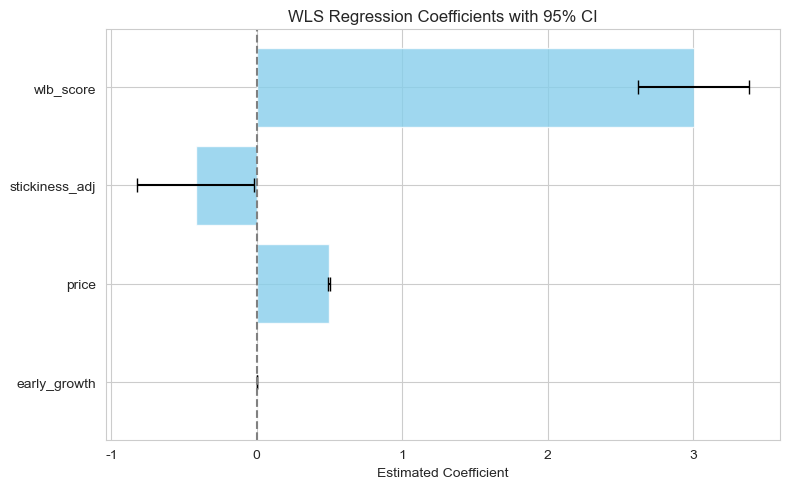

In [289]:
import matplotlib.pyplot as plt

# 1️⃣ 提取系数和置信区间
coef = wls_results.params
conf = wls_results.conf_int()
conf.columns = ['lower', 'upper']

# 去掉常数项，如果不想画 const 可以直接 drop
coef_plot = coef.drop('const')
conf_plot = conf.drop('const')

# 2️⃣ 可视化
plt.figure(figsize=(8, 5))
plt.barh(coef_plot.index, coef_plot.values, xerr=[coef_plot.values - conf_plot['lower'], 
                                                  conf_plot['upper'] - coef_plot.values],
         color='skyblue', alpha=0.8, capsize=5)
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel('Estimated Coefficient')
plt.title('WLS Regression Coefficients with 95% CI')
plt.tight_layout()
plt.show()

/var/folders/dh/ldptd_p50b56gxq9cz8mf1nr0000gn/T/ipykernel_66750/4238206343.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='VIF', y='feature', data=vif_data, palette='viridis', ax=axes[1,0])


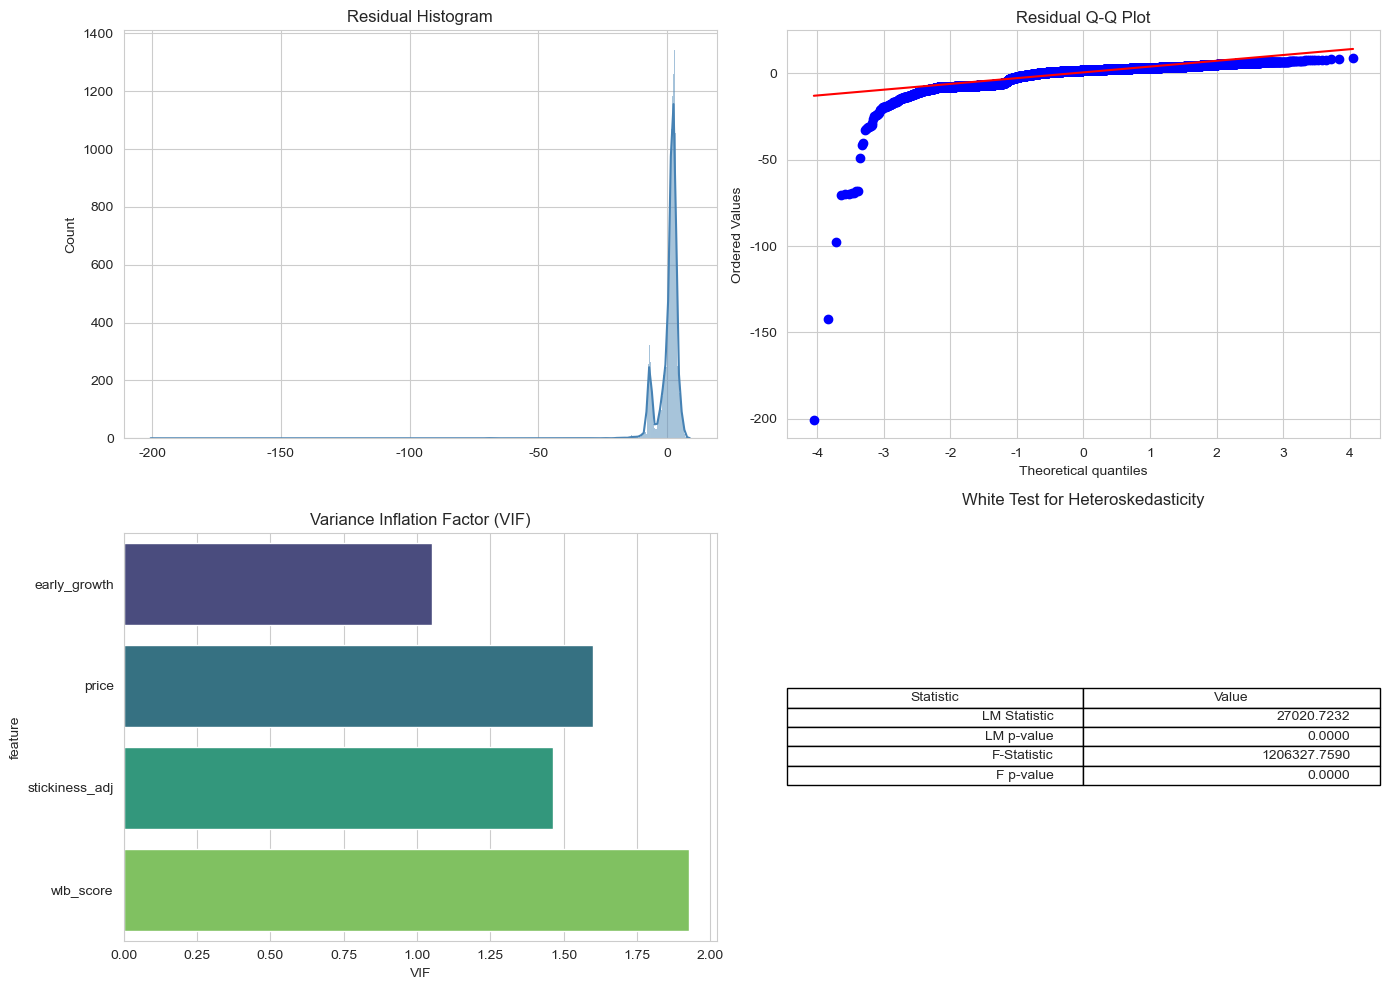

In [290]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats

# 计算残差
residuals = y_log - wls_results.predict(X)

# 1️⃣ VIF
X_vif = X.drop(columns='const')
vif_data = pd.DataFrame({
    "feature": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})

# 2️⃣ White检验
white_test = sms.het_white(residuals, X)
white_labels = ['LM Statistic', 'LM p-value', 'F-Statistic', 'F p-value']
white_results = pd.Series(white_test, index=white_labels)

# 3️⃣ 可视化
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 残差直方图
sns.histplot(residuals, kde=True, ax=axes[0,0], color='steelblue')
axes[0,0].set_title('Residual Histogram')

# 残差 Q-Q 图
stats.probplot(residuals, dist="norm", plot=axes[0,1])
axes[0,1].set_title('Residual Q-Q Plot')

# VIF条形图
sns.barplot(x='VIF', y='feature', data=vif_data, palette='viridis', ax=axes[1,0])
axes[1,0].set_title('Variance Inflation Factor (VIF)')

# White检验结果表格
axes[1,1].axis('off')
table_data = pd.DataFrame({
    'Statistic': white_labels,
    'Value': [f"{v:.4f}" for v in white_test]
})
axes[1,1].table(cellText=table_data.values,
                 colLabels=table_data.columns,
                 loc='center')
axes[1,1].set_title('White Test for Heteroskedasticity', pad=20)

plt.tight_layout()
plt.show()

/Users/mac/anaconda3/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/var/folders/dh/ldptd_p50b56gxq9cz8mf1nr0000gn/T/ipykernel_66750/3061617735.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='VIF', y='feature', data=vif_data, palette='viridis', ax=axes[1,0])


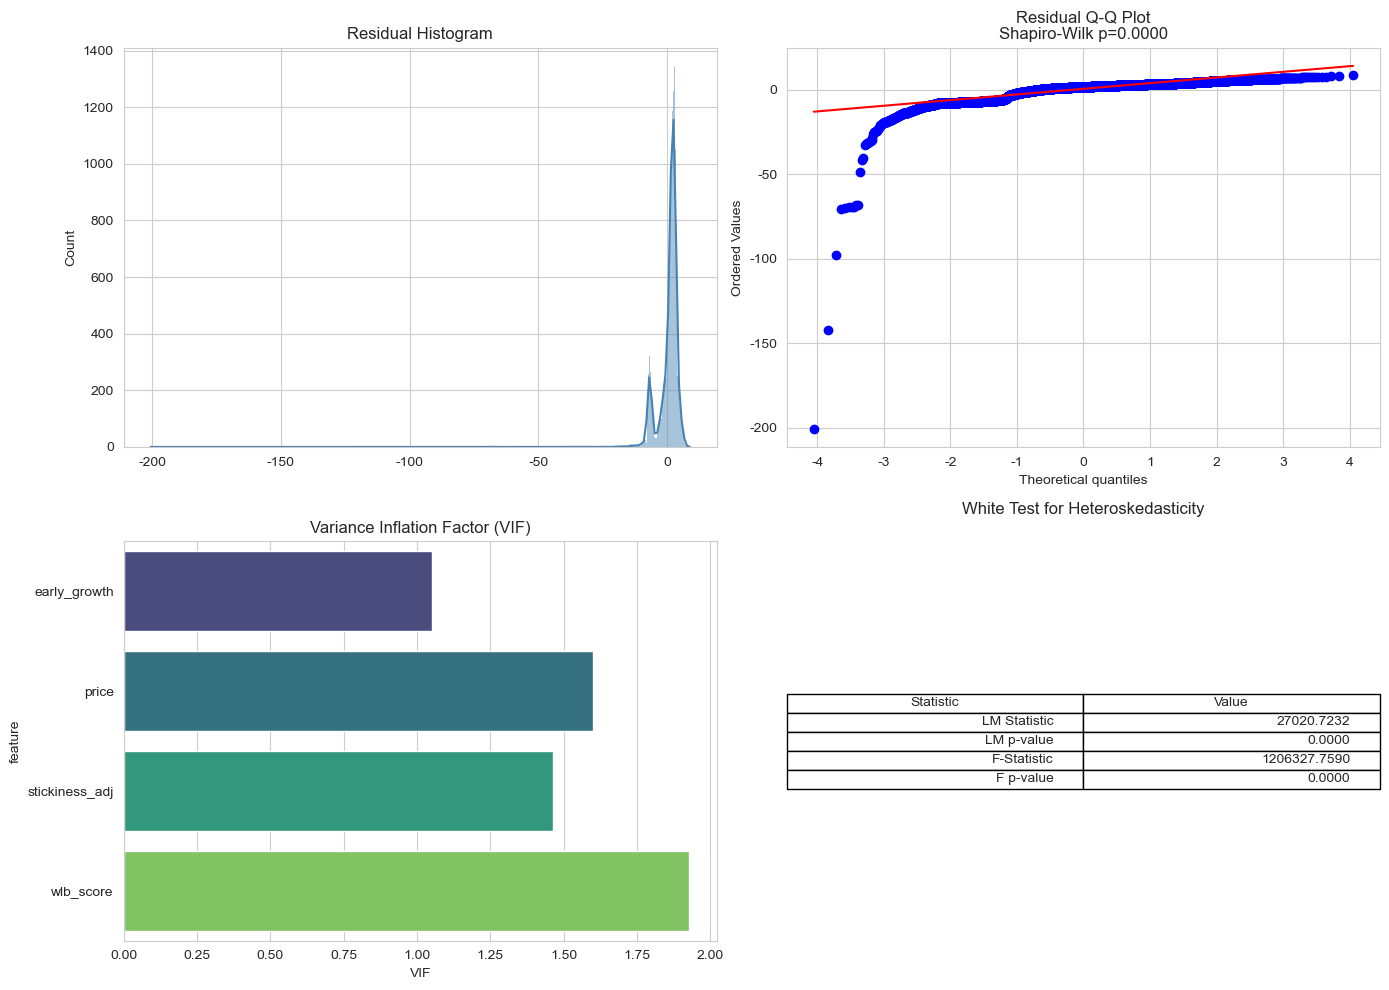

In [291]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats

# 计算残差
residuals = y_log - wls_results.predict(X)

# 1️⃣ VIF
X_vif = X.drop(columns='const')
vif_data = pd.DataFrame({
    "feature": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})

# 2️⃣ White检验
white_test = sms.het_white(residuals, X)
white_labels = ['LM Statistic', 'LM p-value', 'F-Statistic', 'F p-value']
white_results = pd.Series(white_test, index=white_labels)

# 3️⃣ Shapiro-Wilk 正态性检验
shapiro_stat, shapiro_p = stats.shapiro(residuals)

# 4️⃣ 可视化
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 残差直方图
sns.histplot(residuals, kde=True, ax=axes[0,0], color='steelblue')
axes[0,0].set_title('Residual Histogram')

# 残差 Q-Q 图
stats.probplot(residuals, dist="norm", plot=axes[0,1])
axes[0,1].set_title(f'Residual Q-Q Plot\nShapiro-Wilk p={shapiro_p:.4f}')

# VIF条形图
sns.barplot(x='VIF', y='feature', data=vif_data, palette='viridis', ax=axes[1,0])
axes[1,0].set_title('Variance Inflation Factor (VIF)')

# White检验结果表格
axes[1,1].axis('off')
table_data = pd.DataFrame({
    'Statistic': white_labels,
    'Value': [f"{v:.4f}" for v in white_test]
})
axes[1,1].table(cellText=table_data.values,
                 colLabels=table_data.columns,
                 loc='center')
axes[1,1].set_title('White Test for Heteroskedasticity', pad=20)

plt.tight_layout()
plt.show()